<a href="https://colab.research.google.com/github/freejae98/freejae98.github.io/blob/master/2022_04_08_Steel_REG_ML_6_1step(1_F)_Opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [ ]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe
# raw_fe = feature_engineering(raw_all)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

In [ ]:
### Functionalize
### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe
# target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
# raw_fe = feature_engineering_year_duplicated(raw_fe, target)

### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
# target = ['count_lag1', 'count_lag2']
# X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)

### scaling of X_train and X_test by X_train_scaler
def feature_engineering_scaling(scaler, X_train, X_test):
    # preprocessing.MinMaxScaler()
    # preprocessing.StandardScaler()
    # preprocessing.RobustScaler()
    # preprocessing.Normalizer()
    scaler = scaler
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                               index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling
# X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)

### extract non-multicollinearity variables by VIF 
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif
# X_colname_vif = feature_engineering_XbyVIF(X_train_femm, 10)
# X_colname_vif

In [ ]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [ ]:
#################################################################################
#
# ----- Feature 1, MLP 버전 -------
#
#################################################################################


# Data Loading
df = pd.read_excel('/content/Rev_dataset.xlsx')
df.set_index('Date', inplace=True)

X_colname = ['MA5']
raw_all = df[X_colname]

# raw_all = df.loc[df['MA5'] != np.nan, :]

#20%는 테스트용 구분함
PCT = 0.2
c_num = int(len(raw_all.index) * (1- PCT))

criteria = raw_all.index[int(c_num)]


# raw_all = df.loc[df.index >= '2019-12-30', X_colname]

# Parameters
# criteria = '2021-09-01'
scaler = preprocessing.MinMaxScaler()
# sequence = 15   # → optimization 진행
batch_size = 16
epoch = 1000
verbose = 0  # 원래는 1
dropout_ratio = 0

#며칠이나 이후 것을 예상할 것인지 (20 = 4주 후)
predict_day = 5*4 # 4주 후


# Feature Engineering
## Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)


#데이터 제대로 들어갔는지 확인
# train = np.array(train)

# aX_train, aY_train = [], []
# for index in range(0, len(train) - sequence - predict_day):
#     aX_train.append(train[index: index + sequence])
#     aY_train.append(train[index + sequence + predict_day])


# Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)



Train_size: (389, 1) Test_size: (98, 1)


X_train: (364, 5, 1) Y_train: (364, 1)
X_test: (73, 5, 1) Y_test: (73, 1)
Reshaping for MLP
X_train: (364, 5) Y_train: (364, 1)
X_test: (73, 5) Y_test: (73, 1)
3/3 [==============================] - 0s 4ms/step - loss: 2.4820e-15 - MAE: 3.1844e-08


MAE      MSE  MAPE
Train 36.19 2,345.72  5.85
Test  64.53 4,954.08  7.11

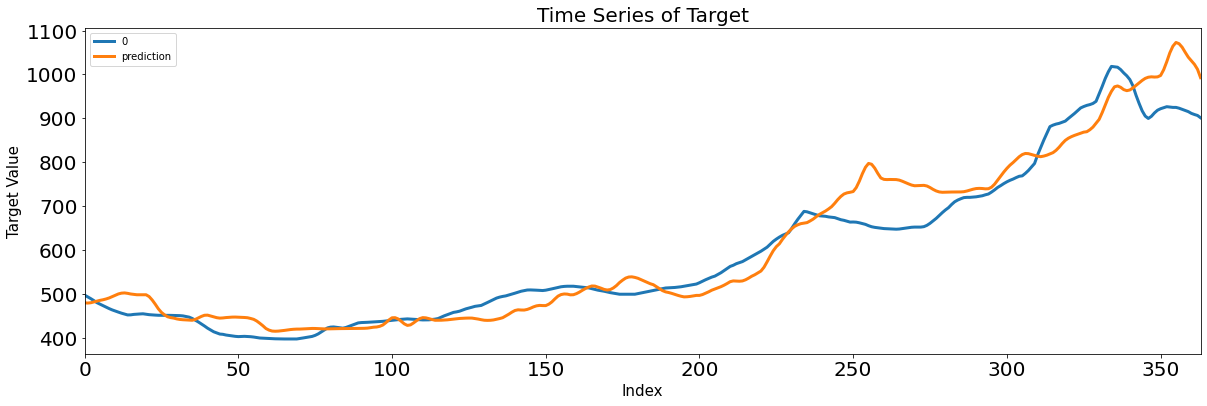

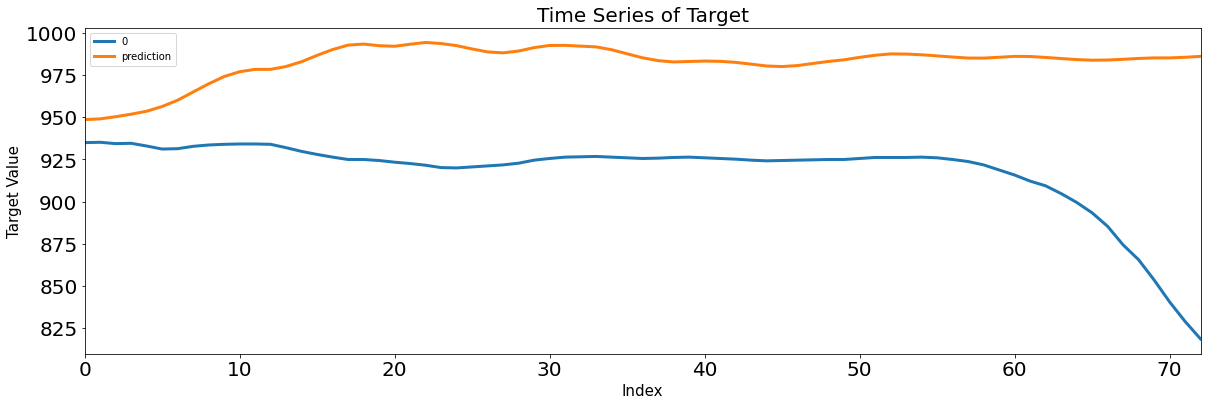

In [ ]:
sequence = 5
epoch = 37

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 50, mode = 'min')


# ####################### iterations #######################
# Score = dict()
# seqsize_list = [i for i in range(1, 21, 1)]
# for i in tqdm(seqsize_list):
#     sequence = i

    # X / Y Split
X_train, Y_train = [], []
for index in range(0, len(train_scaled) - sequence - predict_day):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence + predict_day])
X_test, Y_test = [], []
for index in range(0, len(test_scaled) - sequence - predict_day):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence + predict_day])
    
    
## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# MLP
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
print('Reshaping for MLP')
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)


model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['MAE'])
# model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose, validation_data=(X_test, Y_test)) #, callbacks = [early_stopping])

# plt.plot(pd.DataFrame(model_fit.history))
# plt.grid(True)
# plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_MLP)
    # Score[str(sequence)] = Score_MLP


# error analysis
# error_analysis(Residual_te, ['Error'], pd.DataFrame(X_test), graph_on=True)

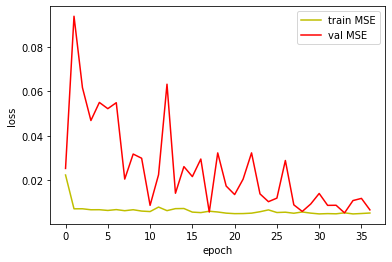

In [ ]:
# 5. 모델 학습과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()

loss_ax.plot(model_fit.history['loss'], 'y', label = 'train MSE')
loss_ax.plot(model_fit.history['val_loss'], 'r', label = 'val MSE')
# acc_ax.plot(model_fit.history['MAE'], 'b', label = 'train MAE')
# acc_ax.plot(model_fit.history['val_MAE'], 'g', label = 'val MAE')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'auto')
# acc_ax.legend(loc = 'lower left')

plt.show()

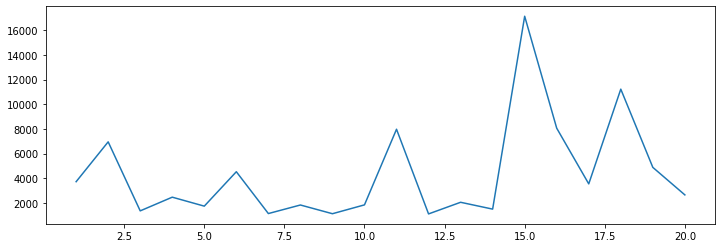

In [ ]:
# Performance plot by sequence length
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = seqsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

X_train: (319, 1, 1) Y_train: (319, 1)
X_test: (126, 1, 1) Y_test: (126, 1)


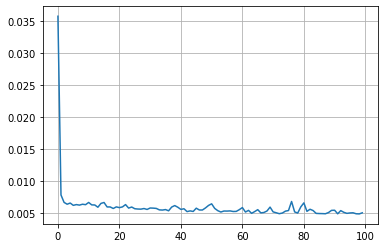

4/4 [==============================] - 0s 4ms/step - loss: 3.3835e-15


MAE      MSE  MAPE
Train 30.09 1,262.39  5.57
Test  64.86 5,583.16  7.13

  5%|▌         | 1/20 [00:12<03:53, 12.27s/it]

X_train: (318, 2, 1) Y_train: (318, 1)
X_test: (125, 2, 1) Y_test: (125, 1)


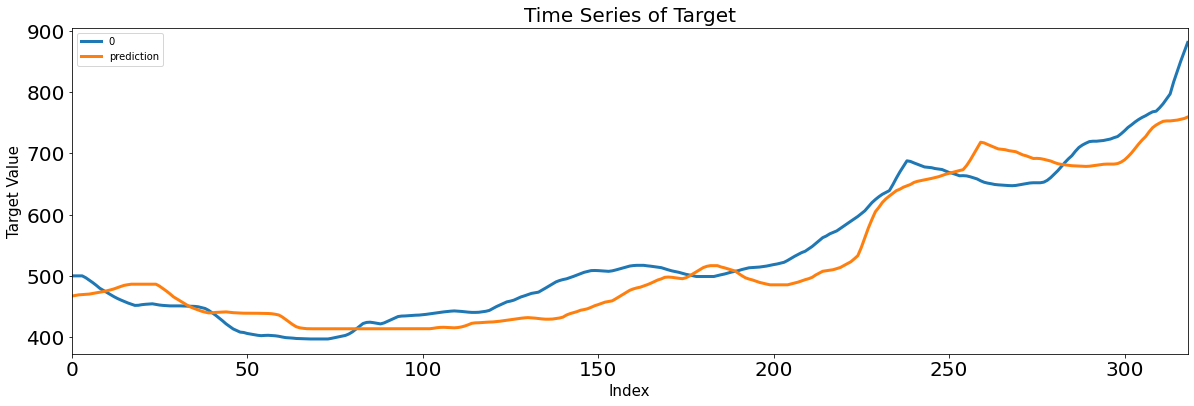

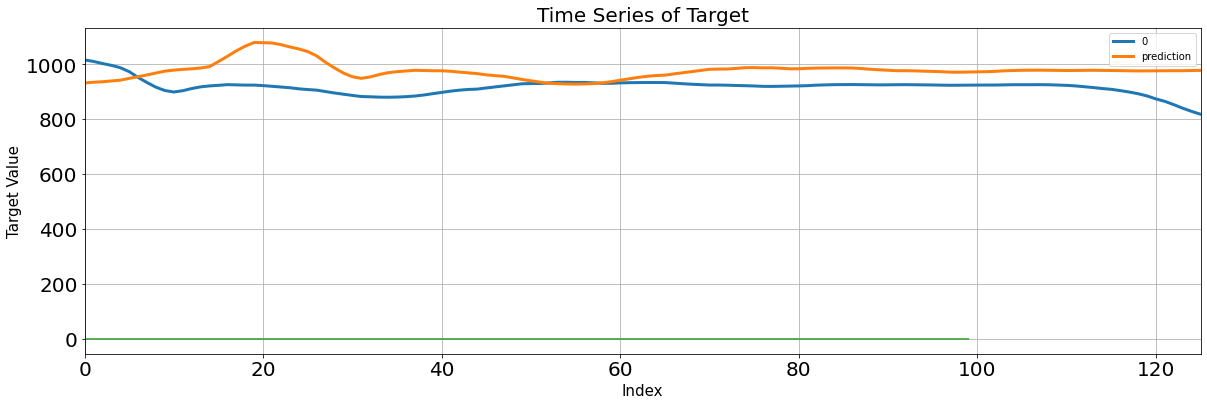

4/4 [==============================] - 0s 5ms/step - loss: 3.0695e-15


MAE      MSE  MAPE
Train 24.01   922.87  4.43
Test  83.63 8,591.90  9.20

 10%|█         | 2/20 [00:29<04:30, 15.04s/it]

X_train: (317, 3, 1) Y_train: (317, 1)
X_test: (124, 3, 1) Y_test: (124, 1)


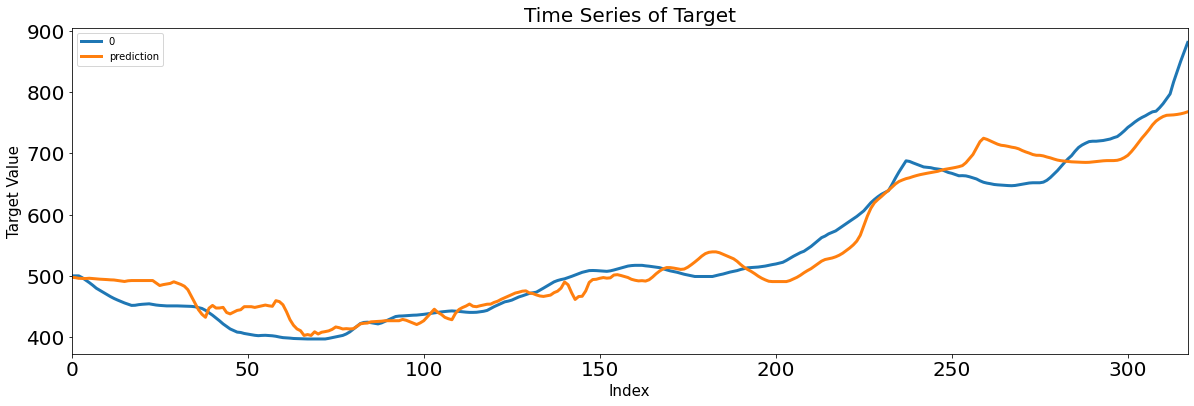

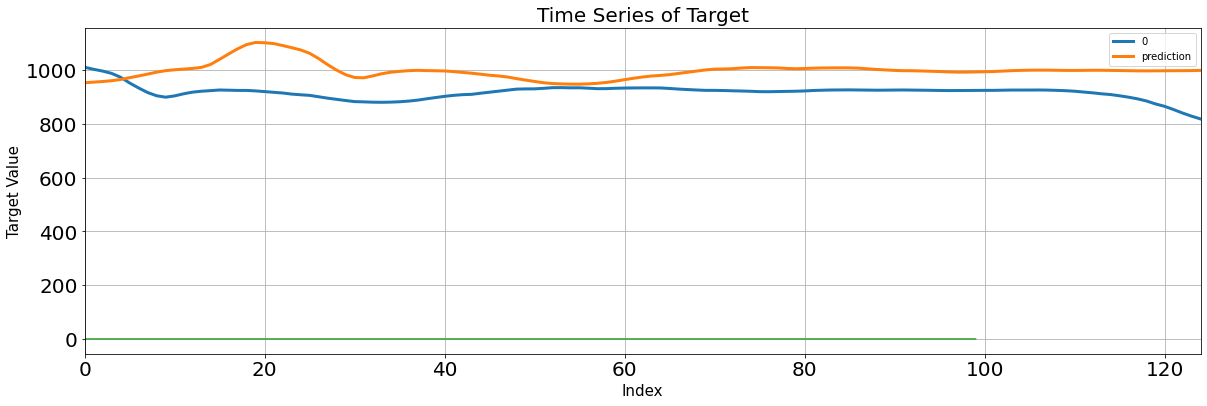

4/4 [==============================] - 0s 4ms/step - loss: 4.8134e-15


MAE       MSE  MAPE
Train  24.00    953.97  4.35
Test  224.39 54,183.82 24.59

 15%|█▌        | 3/20 [00:48<04:45, 16.77s/it]

X_train: (316, 4, 1) Y_train: (316, 1)
X_test: (123, 4, 1) Y_test: (123, 1)


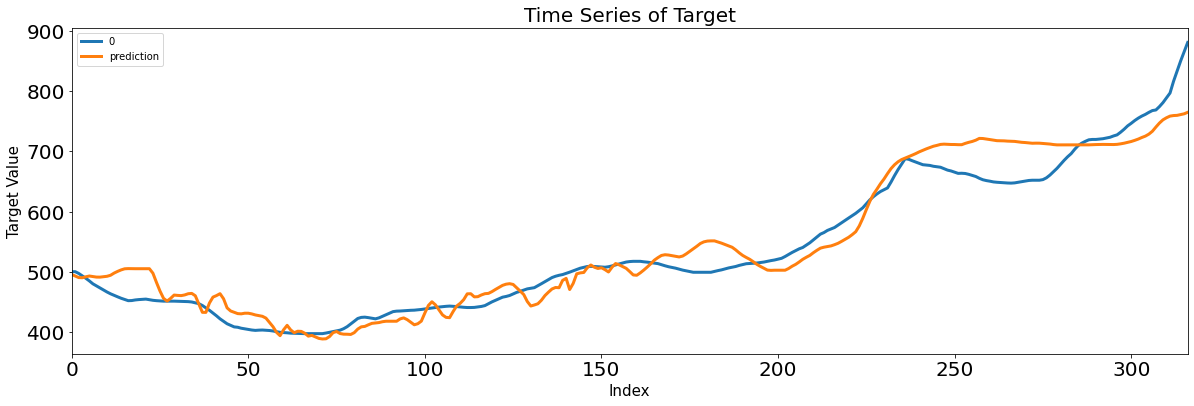

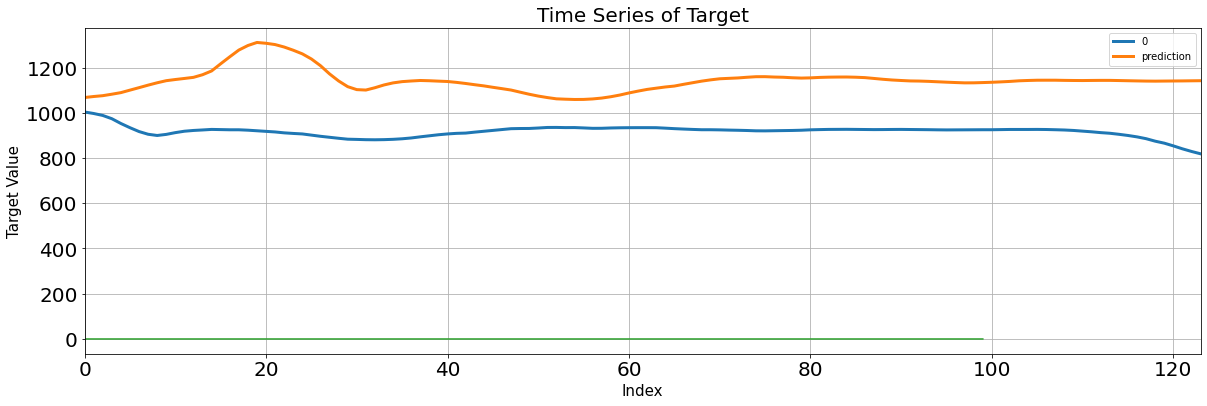

4/4 [==============================] - 0s 7ms/step - loss: 6.2389e-15


MAE       MSE  MAPE
Train  23.56  1,201.40  4.31
Test  147.36 23,846.83 16.18

 20%|██        | 4/20 [01:08<04:54, 18.41s/it]

X_train: (315, 5, 1) Y_train: (315, 1)
X_test: (122, 5, 1) Y_test: (122, 1)


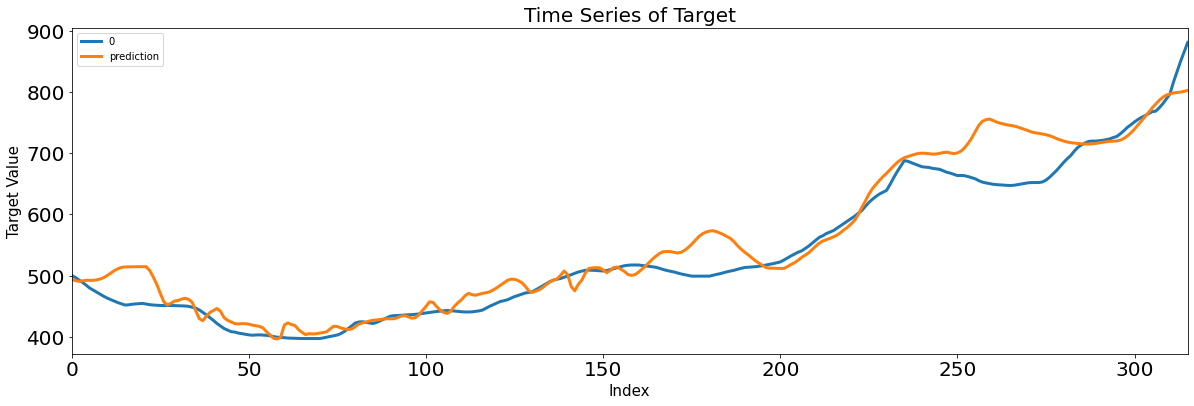

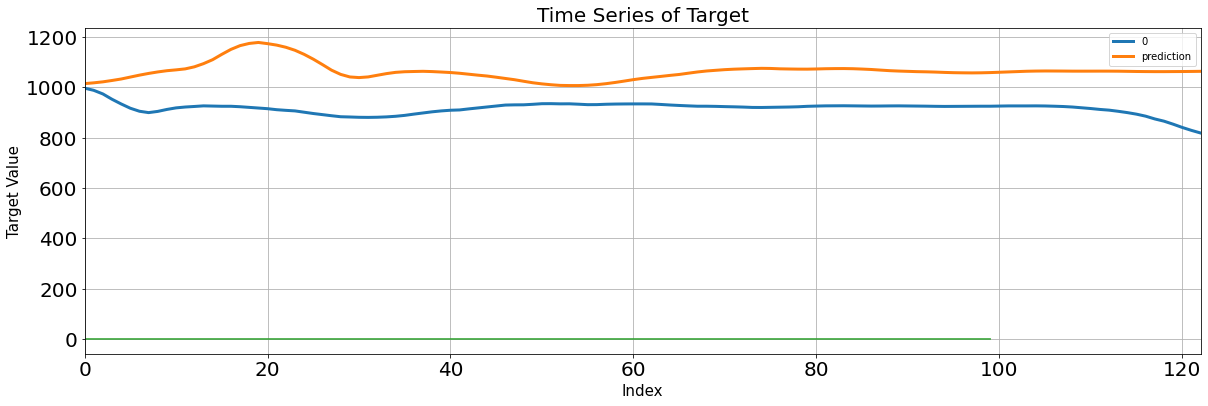

4/4 [==============================] - 0s 6ms/step - loss: 5.1252e-15


MAE       MSE  MAPE
Train  19.36    757.99  3.35
Test  122.98 17,017.77 13.52

 25%|██▌       | 5/20 [01:33<05:09, 20.62s/it]

X_train: (314, 6, 1) Y_train: (314, 1)
X_test: (121, 6, 1) Y_test: (121, 1)


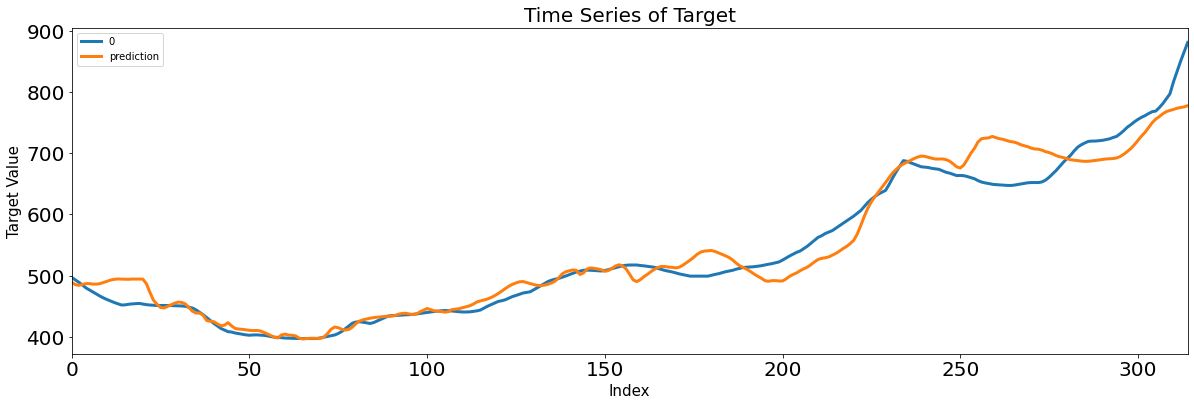

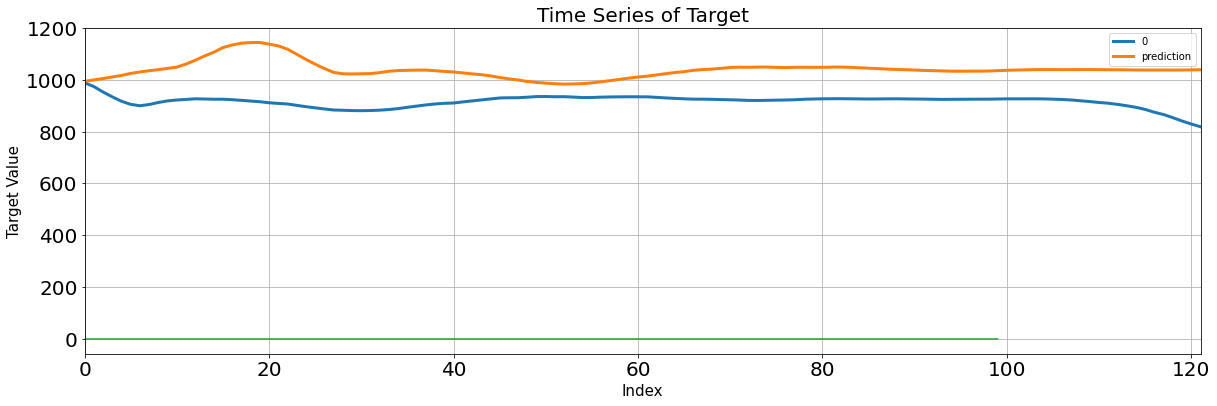

4/4 [==============================] - 0s 7ms/step - loss: 5.1676e-15


MAE       MSE  MAPE
Train  20.82    791.77  3.66
Test  126.87 17,845.68 13.95

 30%|███       | 6/20 [02:00<05:17, 22.68s/it]

X_train: (313, 7, 1) Y_train: (313, 1)
X_test: (120, 7, 1) Y_test: (120, 1)


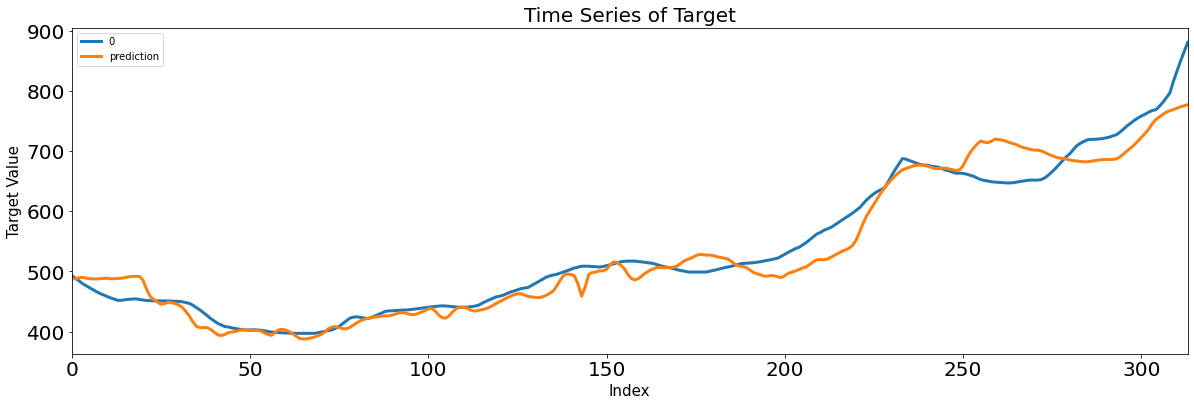

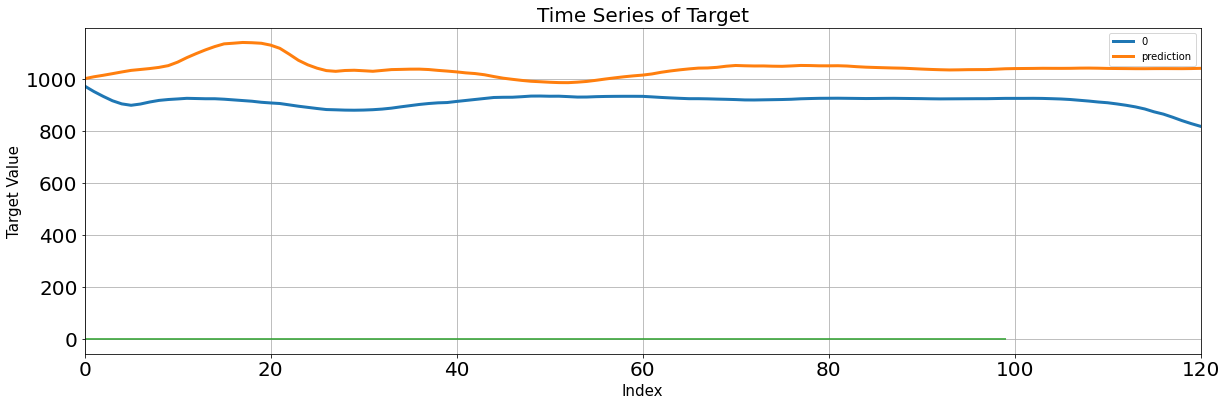

4/4 [==============================] - 0s 8ms/step - loss: 7.5791e-15


MAE      MSE  MAPE
Train 22.91   896.26  4.01
Test  76.27 7,380.81  8.41

 35%|███▌      | 7/20 [02:29<05:24, 24.99s/it]

X_train: (312, 8, 1) Y_train: (312, 1)
X_test: (119, 8, 1) Y_test: (119, 1)


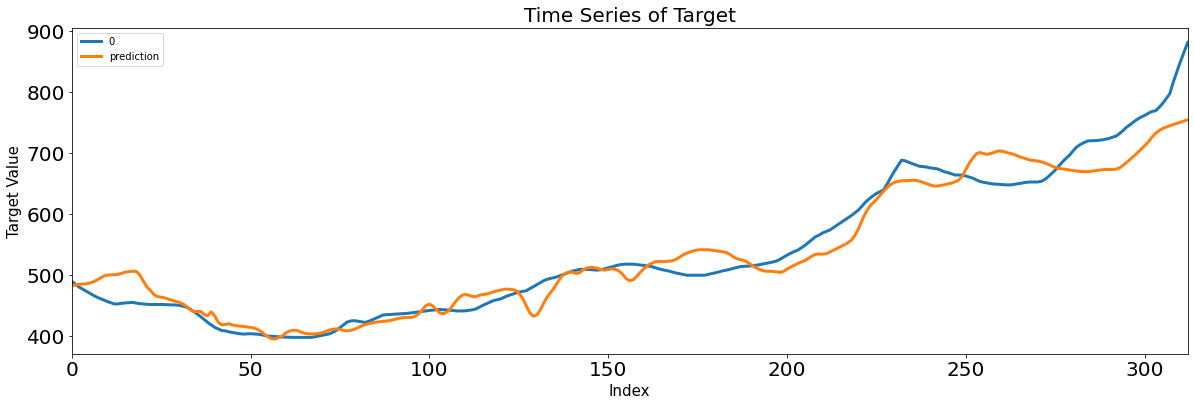

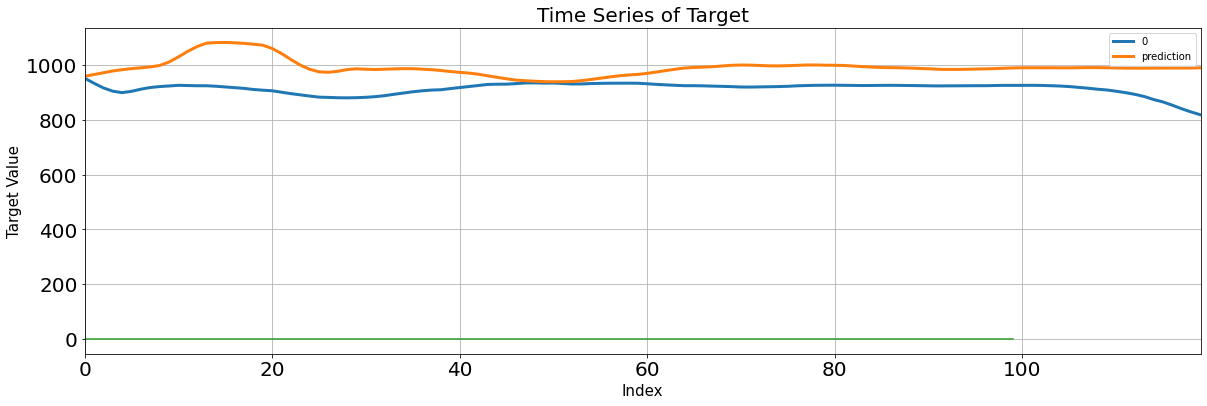

4/4 [==============================] - 1s 8ms/step - loss: 9.7924e-15


MAE       MSE  MAPE
Train  20.49    976.23  3.55
Test  138.73 20,770.26 15.25

 40%|████      | 8/20 [03:02<05:26, 27.23s/it]

X_train: (311, 9, 1) Y_train: (311, 1)
X_test: (118, 9, 1) Y_test: (118, 1)


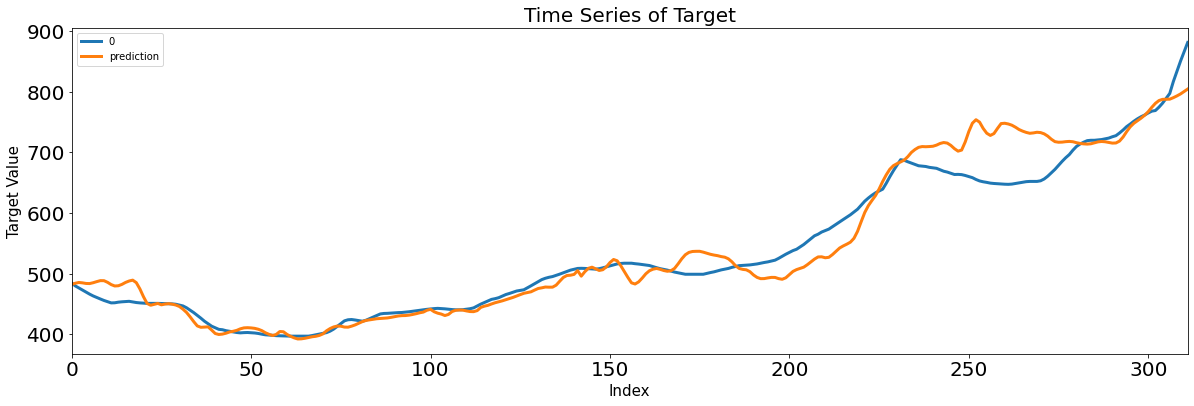

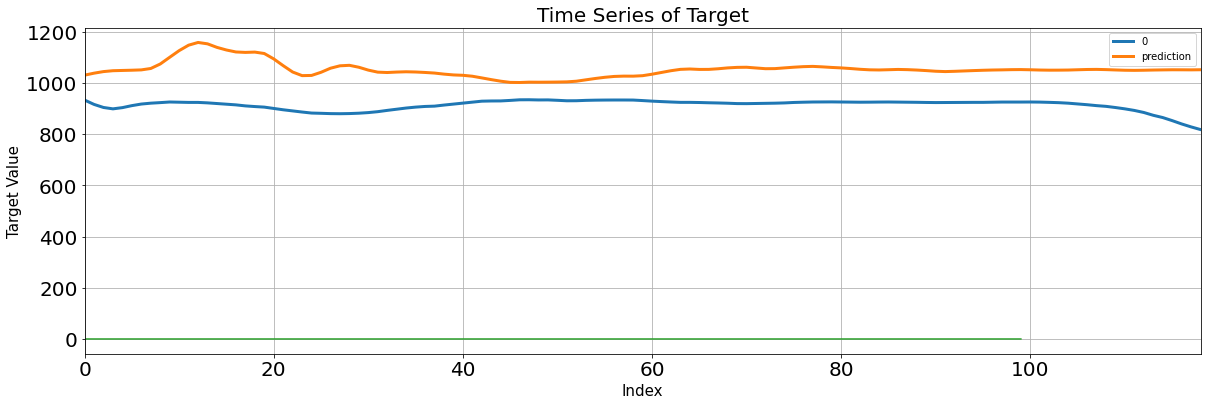

4/4 [==============================] - 1s 9ms/step - loss: 6.7441e-15


MAE       MSE  MAPE
Train  17.35    717.42  2.94
Test  112.06 14,012.12 12.33

 45%|████▌     | 9/20 [03:36<05:25, 29.59s/it]

X_train: (310, 10, 1) Y_train: (310, 1)
X_test: (117, 10, 1) Y_test: (117, 1)


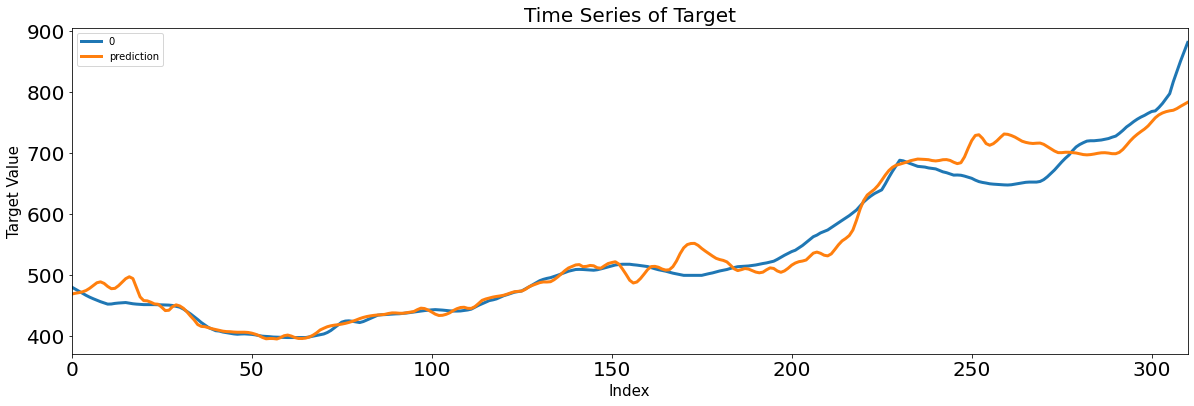

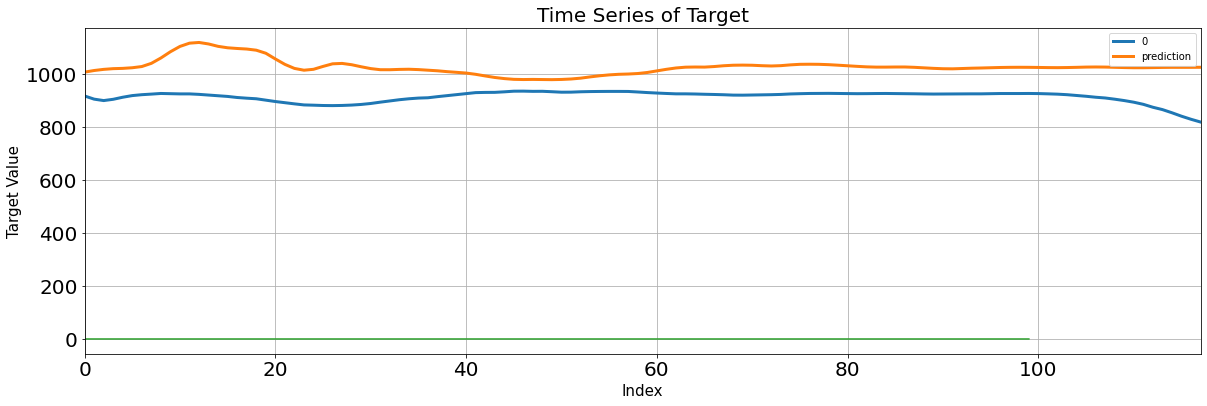

4/4 [==============================] - 1s 8ms/step - loss: 6.9232e-15


MAE      MSE  MAPE
Train 19.45   763.72  3.26
Test  91.02 9,736.50 10.03

 50%|█████     | 10/20 [04:14<05:21, 32.14s/it]

X_train: (309, 11, 1) Y_train: (309, 1)
X_test: (116, 11, 1) Y_test: (116, 1)


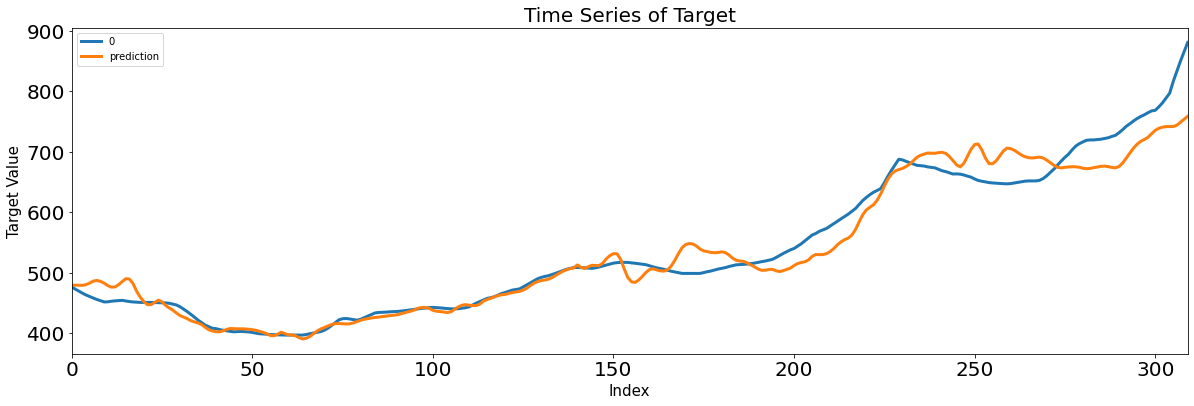

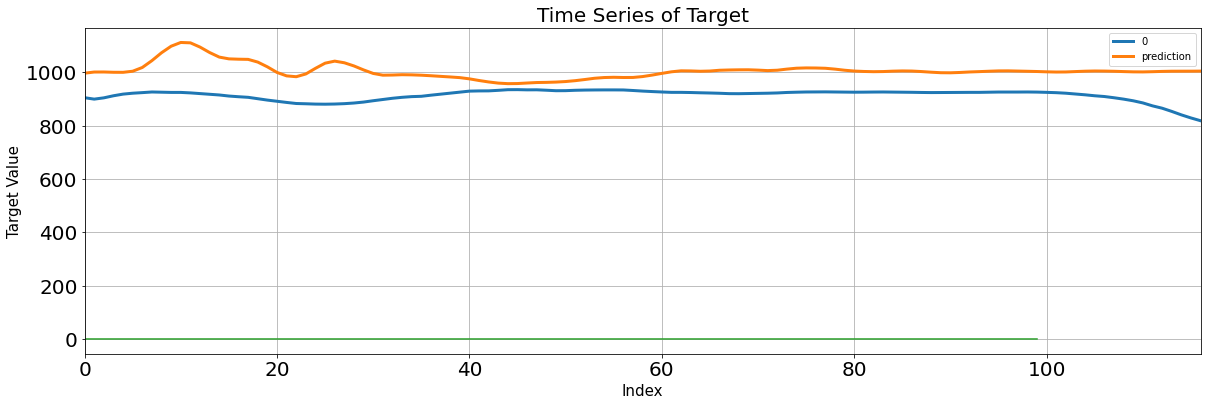

4/4 [==============================] - 1s 9ms/step - loss: 6.9829e-15


MAE       MSE  MAPE
Train  18.21    870.94  3.09
Test  119.67 15,872.18 13.17

 55%|█████▌    | 11/20 [04:54<05:11, 34.59s/it]

X_train: (308, 12, 1) Y_train: (308, 1)
X_test: (115, 12, 1) Y_test: (115, 1)


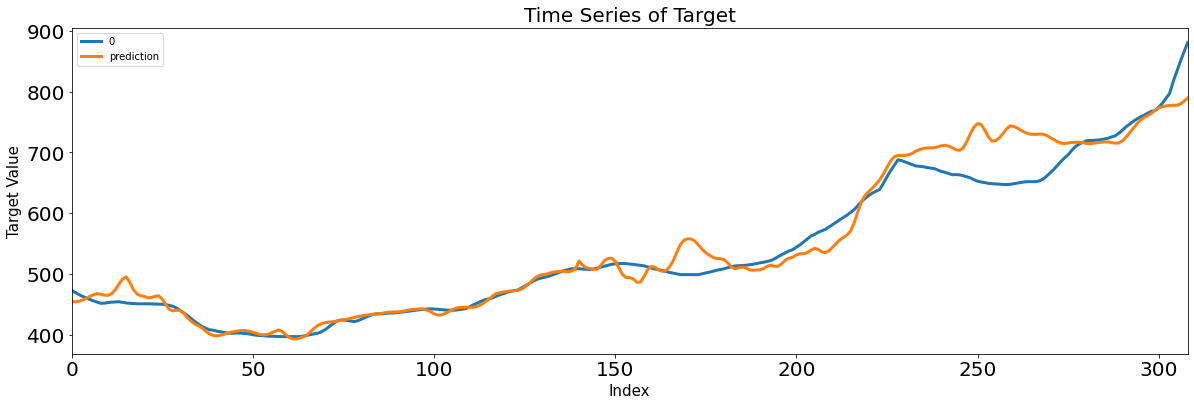

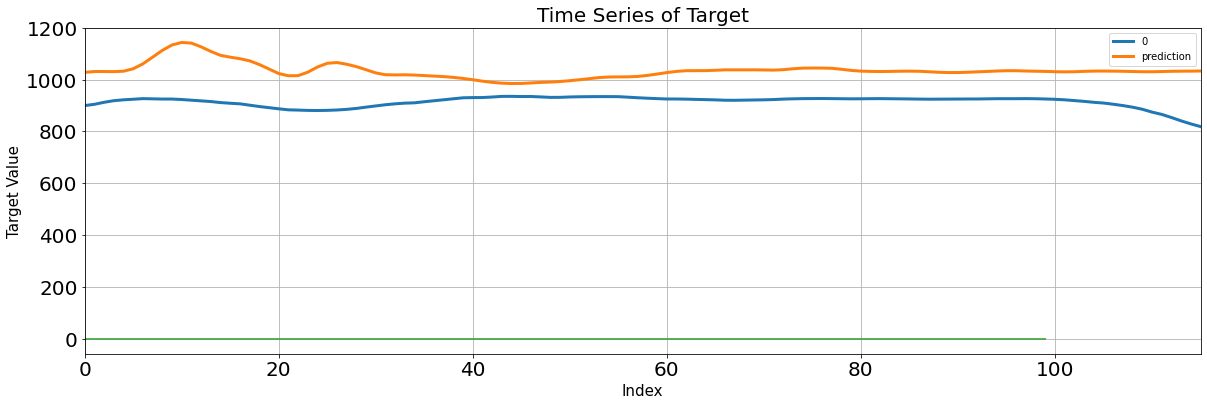

4/4 [==============================] - 1s 10ms/step - loss: 1.3346e-14


MAE       MSE  MAPE
Train  19.77    801.35  3.43
Test  124.50 17,234.36 13.69

 60%|██████    | 12/20 [05:37<04:57, 37.15s/it]

X_train: (307, 13, 1) Y_train: (307, 1)
X_test: (114, 13, 1) Y_test: (114, 1)


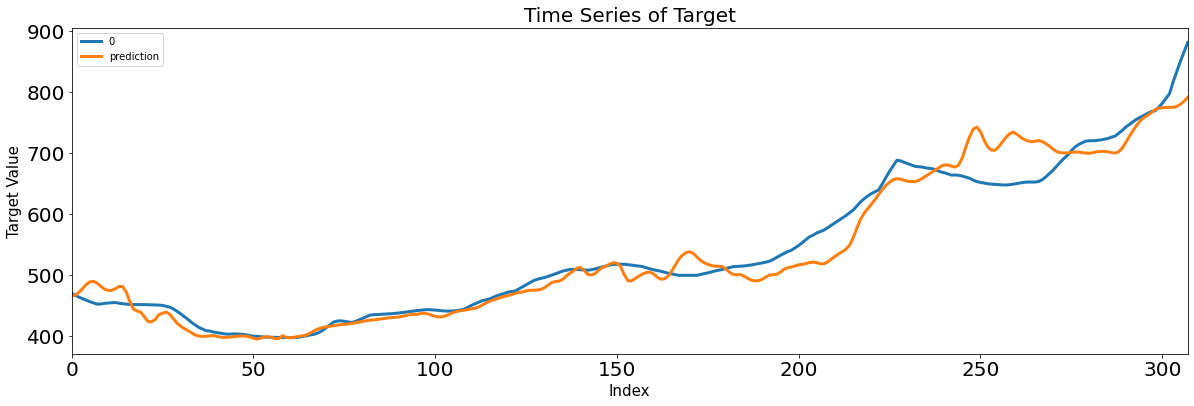

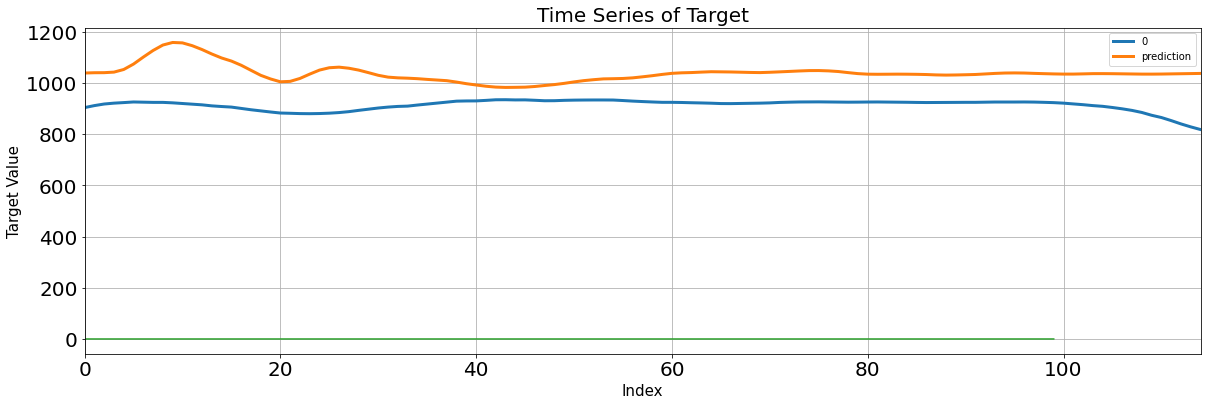

4/4 [==============================] - 1s 11ms/step - loss: 8.4767e-15


MAE      MSE  MAPE
Train 21.30   795.63  3.70
Test  46.81 3,294.21  5.18

 65%|██████▌   | 13/20 [06:23<04:39, 39.87s/it]

X_train: (306, 14, 1) Y_train: (306, 1)
X_test: (113, 14, 1) Y_test: (113, 1)


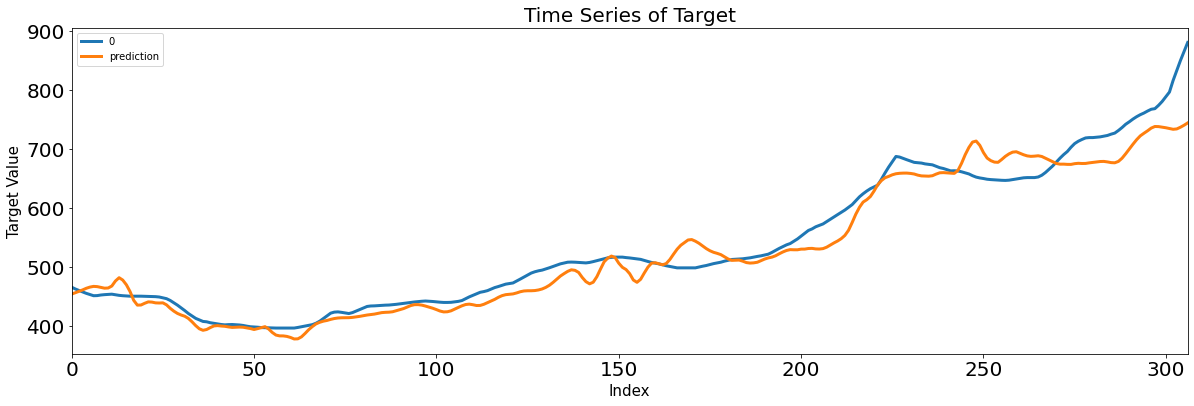

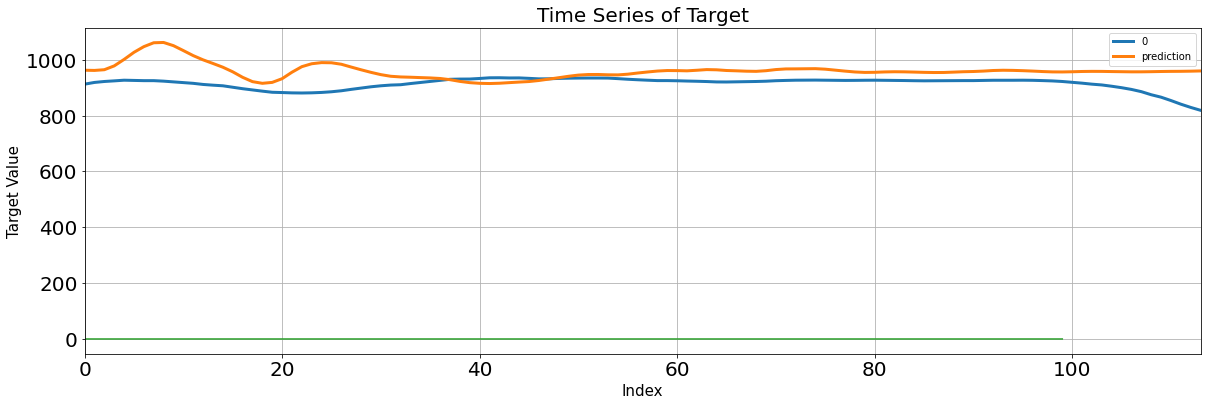

4/4 [==============================] - 1s 12ms/step - loss: 4.1501e-15


MAE      MSE  MAPE
Train 17.73   759.71  2.91
Test  48.10 3,448.81  5.33

 70%|███████   | 14/20 [07:13<04:17, 42.95s/it]

X_train: (305, 15, 1) Y_train: (305, 1)
X_test: (112, 15, 1) Y_test: (112, 1)


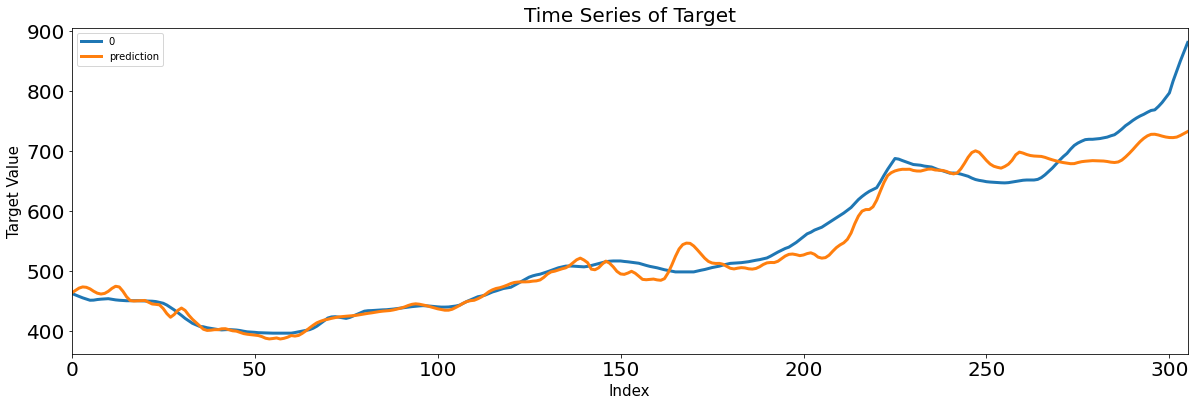

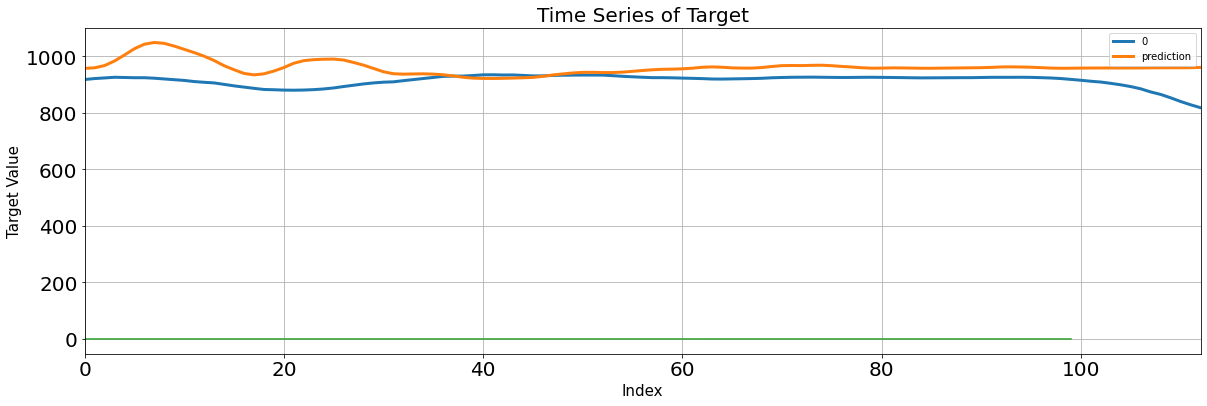

4/4 [==============================] - 1s 11ms/step - loss: 9.8968e-15


MAE       MSE  MAPE
Train  20.18    790.17  3.58
Test  100.78 11,860.52 11.09

 75%|███████▌  | 15/20 [08:05<03:47, 45.41s/it]

X_train: (304, 16, 1) Y_train: (304, 1)
X_test: (111, 16, 1) Y_test: (111, 1)


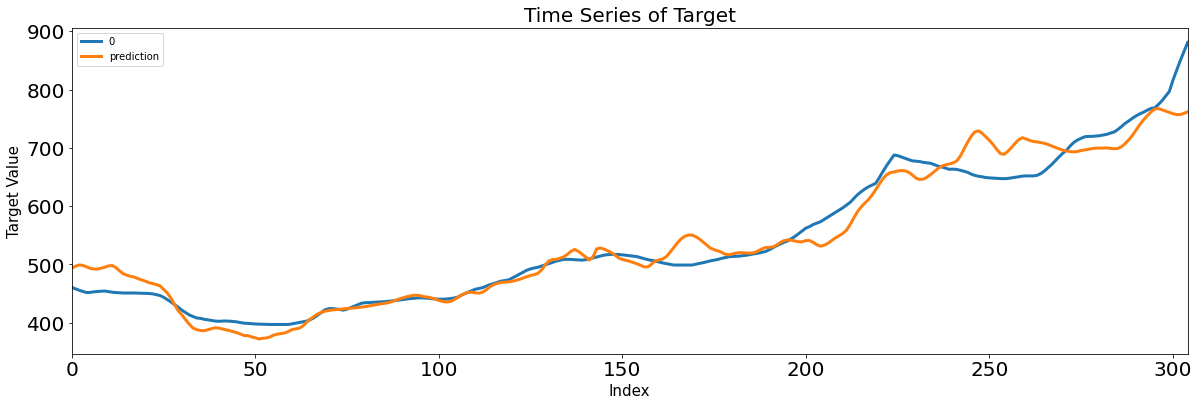

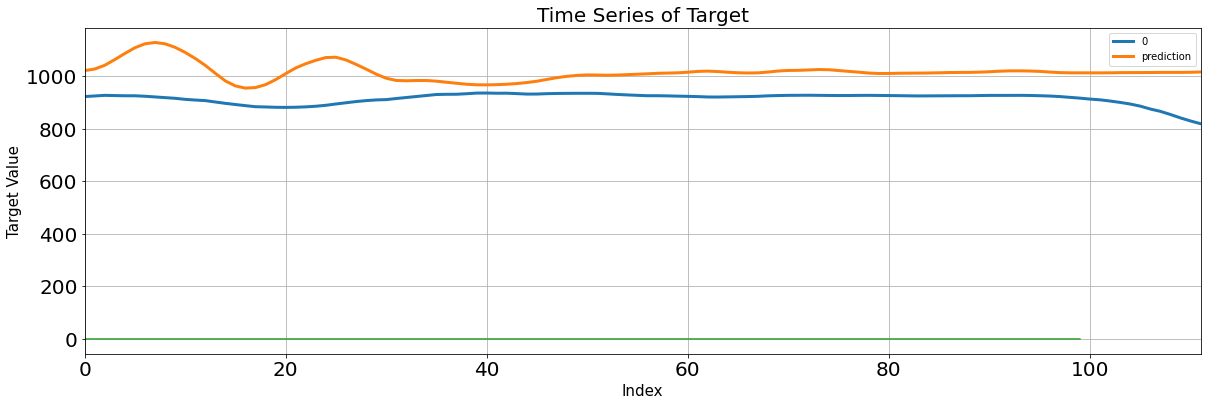

4/4 [==============================] - 1s 13ms/step - loss: 8.4497e-15


MAE       MSE  MAPE
Train  16.70    665.53  2.73
Test  140.67 22,032.73 15.46

 80%|████████  | 16/20 [08:53<03:04, 46.17s/it]

X_train: (303, 17, 1) Y_train: (303, 1)
X_test: (110, 17, 1) Y_test: (110, 1)


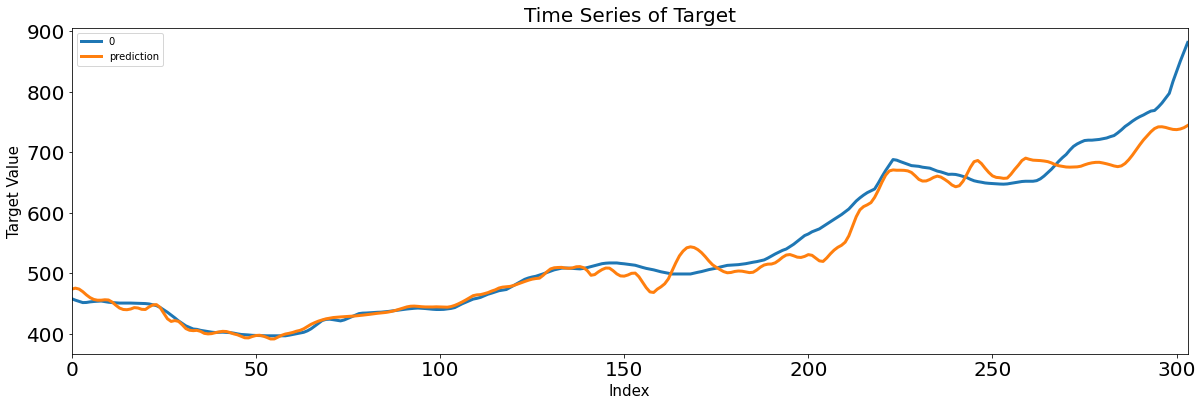

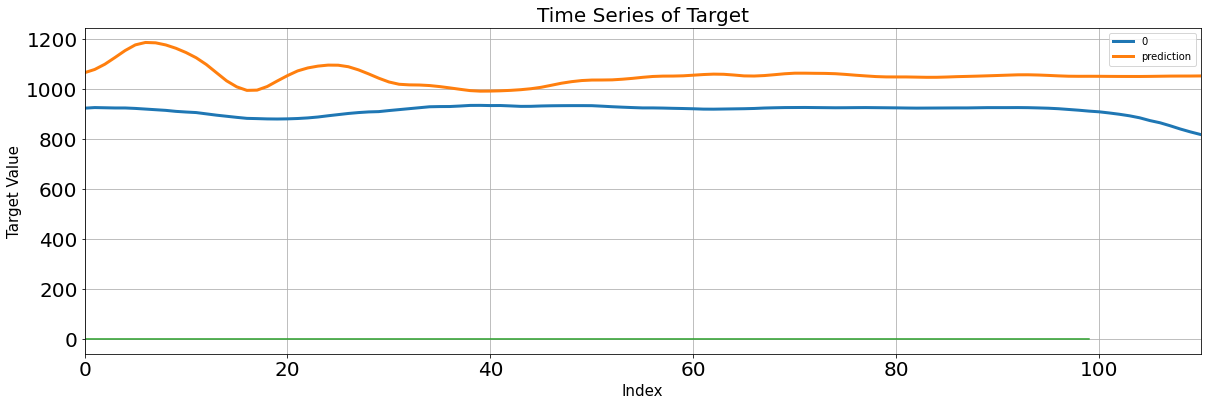

4/4 [==============================] - 1s 13ms/step - loss: 8.6557e-15


MAE       MSE  MAPE
Train  15.80    581.29  2.68
Test  147.42 23,895.17 16.20

 85%|████████▌ | 17/20 [09:48<02:26, 48.94s/it]

X_train: (302, 18, 1) Y_train: (302, 1)
X_test: (109, 18, 1) Y_test: (109, 1)


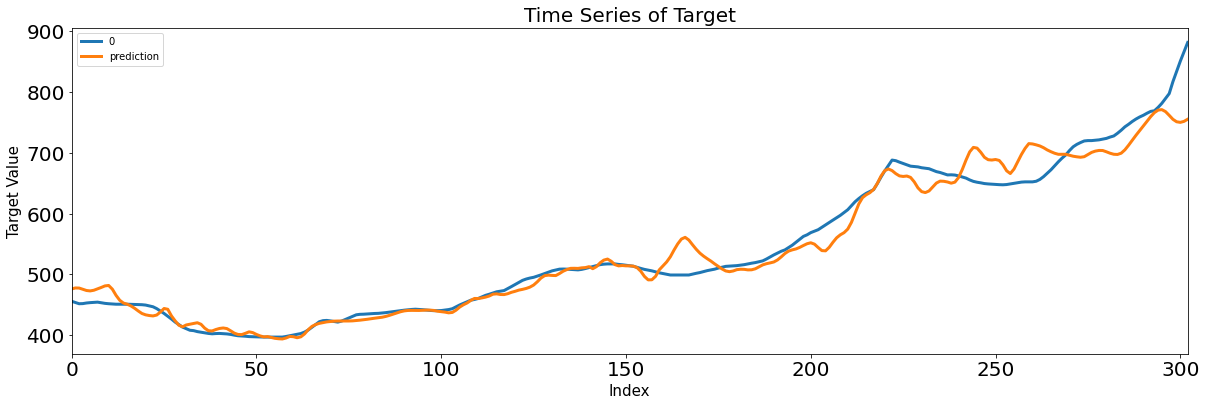

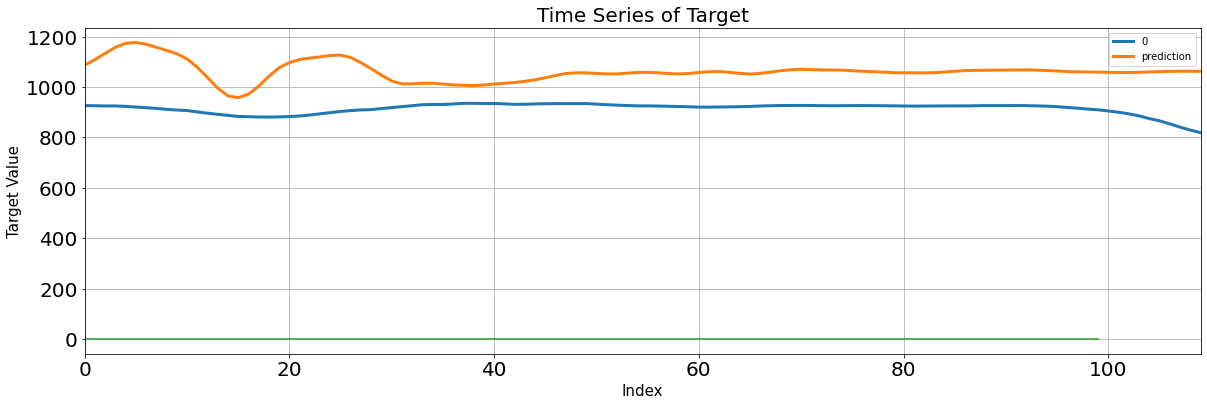

4/4 [==============================] - 1s 14ms/step - loss: 1.7340e-14


MAE       MSE  MAPE
Train  14.56    561.71  2.50
Test  252.68 69,380.87 27.70

 90%|█████████ | 18/20 [10:45<01:42, 51.49s/it]

X_train: (301, 19, 1) Y_train: (301, 1)
X_test: (108, 19, 1) Y_test: (108, 1)


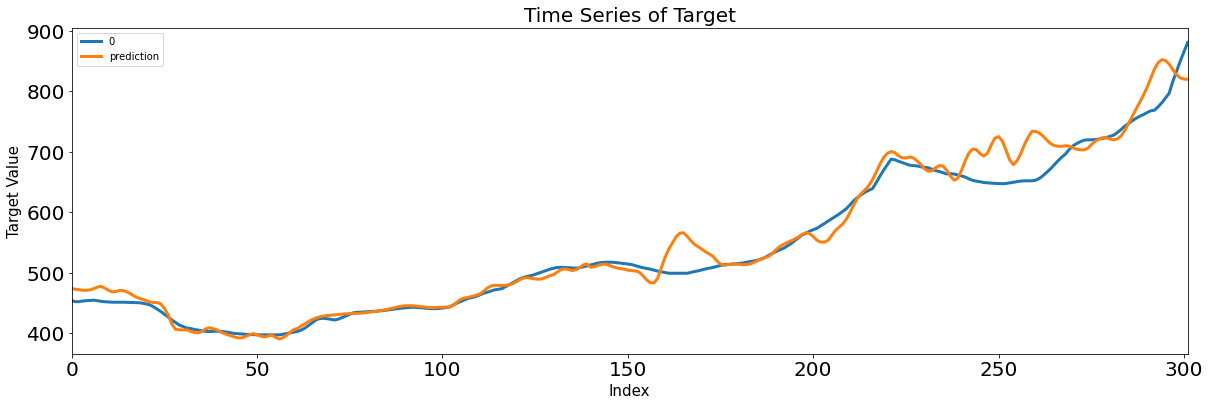

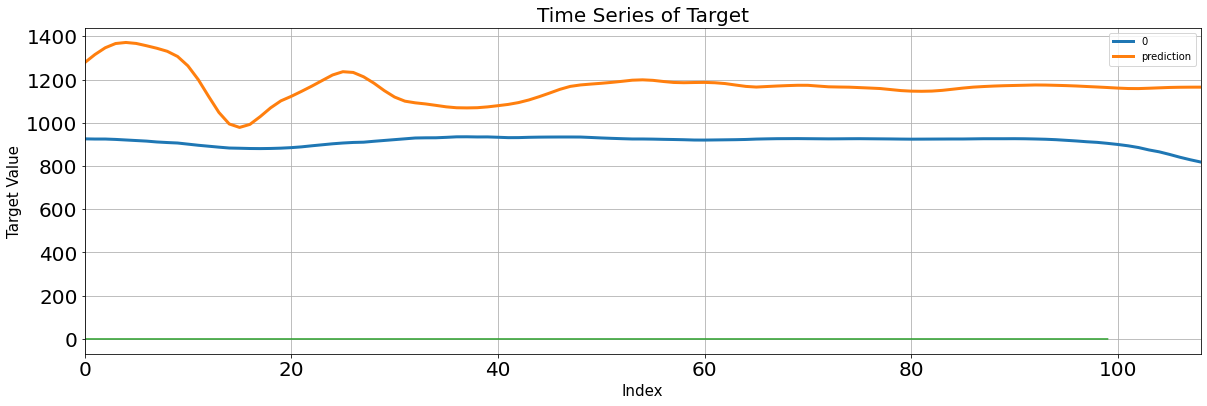

4/4 [==============================] - 1s 15ms/step - loss: 1.4079e-14


MAE       MSE  MAPE
Train  13.06    528.42  2.19
Test  196.07 41,101.17 21.53

 95%|█████████▌| 19/20 [11:45<00:54, 54.09s/it]

X_train: (300, 20, 1) Y_train: (300, 1)
X_test: (107, 20, 1) Y_test: (107, 1)


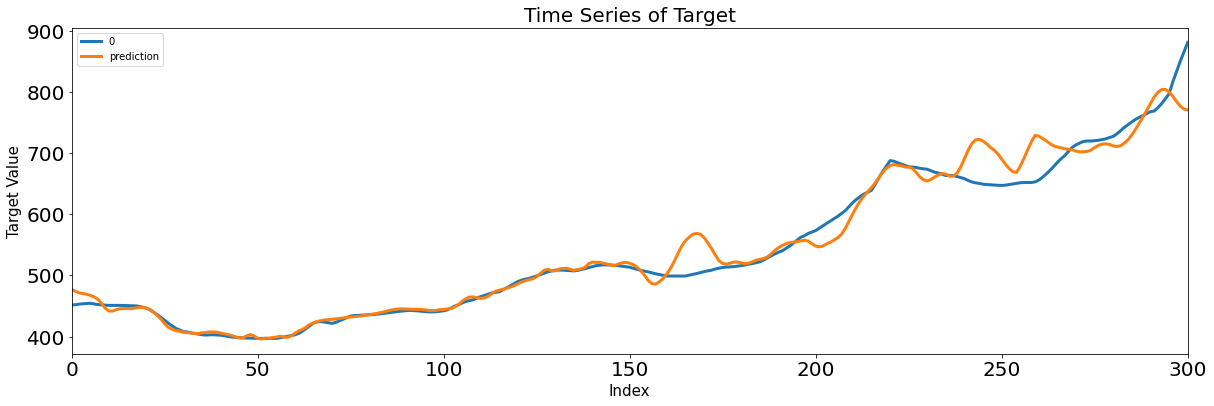

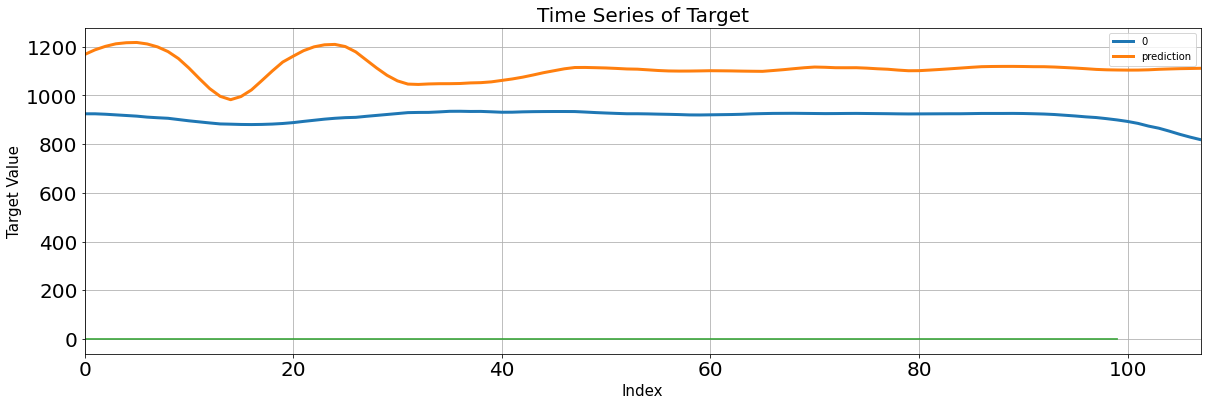

4/4 [==============================] - 1s 16ms/step - loss: 1.3680e-14


MAE       MSE  MAPE
Train  16.92    522.17  3.19
Test  190.29 39,348.90 20.89

100%|██████████| 20/20 [12:48<00:00, 38.44s/it]


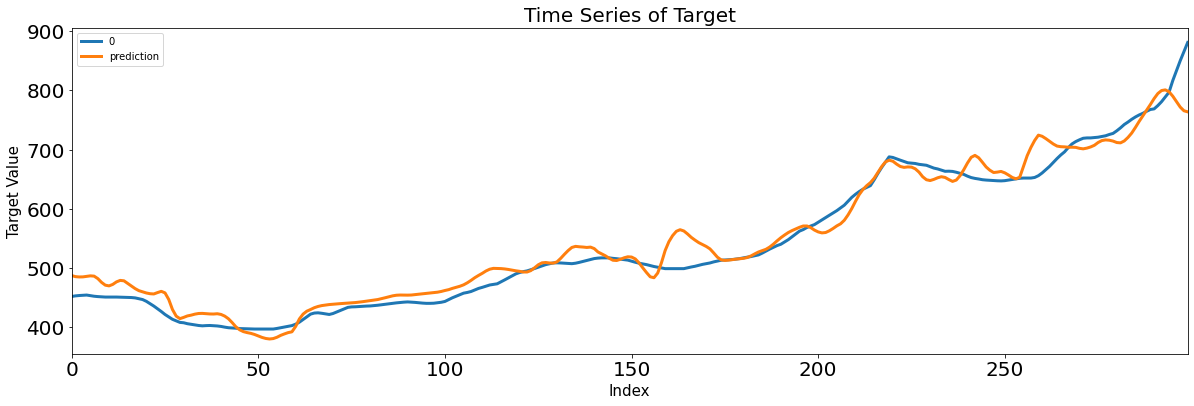

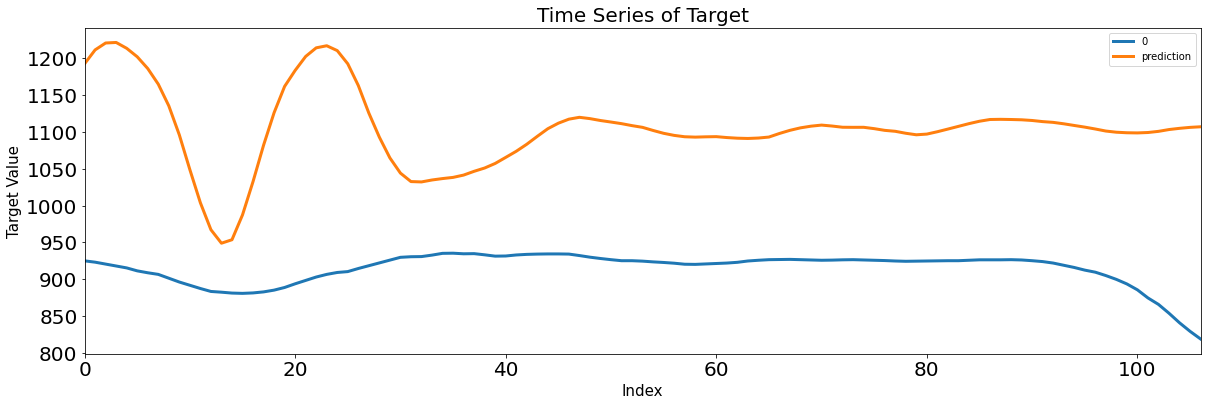

In [ ]:
#################################################################################
#
# ----- Feature 1, RNN 버전 -------
#
#################################################################################


# Data Loading
# df = pd.read_excel('/content/Rev_dataset.xlsx')
# df.set_index('Date', inplace=True)

# X_colname = ['MA5']
# raw_all = df[X_colname]

# raw_all = df.loc[df['MA5'] != np.nan, :]

#20%는 테스트용 구분함
# PCT = 0.2
# c_num = round(len(raw_all.index) * (1- PCT), 0)

# criteria = raw_all.index[int(c_num)]


# raw_all = df.loc[df.index >= '2019-12-30', X_colname]

# Parameters
# criteria = '2021-09-01'
# scaler = preprocessing.MinMaxScaler()
# sequence = 30
# batch_size = 32
# epoch = 100
# verbose = 1
# dropout_ratio = 0

# # Feature Engineering
# ## Train & Test Split
# train = raw_all.loc[raw_all.index < criteria,:]
# test = raw_all.loc[raw_all.index >= criteria,:]
# print('Train_size:', train.shape, 'Test_size:', test.shape)

# ## Scaling
# train_scaled = scaler.fit_transform(train)
# test_scaled = scaler.transform(test)



####################### iterations #######################
Score = dict()
seqsize_list = [i for i in range(1, 21, 1)]
for i in tqdm(seqsize_list):
    sequence = i

    # ## X / Y Split
    X_train, Y_train = [], []
    for index in range(0, len(train_scaled) - sequence - predict_day):
        X_train.append(train_scaled[index: index + sequence])
        Y_train.append(train_scaled[index + sequence + predict_day])
    X_test, Y_test = [], []
    for index in range(0, len(test_scaled) - sequence - predict_day):
        X_test.append(test_scaled[index: index + sequence])
        Y_test.append(test_scaled[index + sequence + predict_day])

    # ## Retype and Reshape
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # RNN
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    plt.plot(pd.DataFrame(model_fit.history))
    plt.grid(True)
    plt.show()

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # evaluation
    result = model.evaluate(X_test, Y_test_pred)
    if scaler != []:
        Y_train = scaler.inverse_transform(Y_train)
        Y_train_pred = scaler.inverse_transform(Y_train_pred)
        Y_test = scaler.inverse_transform(Y_test)
        Y_test_pred = scaler.inverse_transform(Y_test_pred)
    Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
    display(Score_RNN)
    Score[str(sequence)] = Score_RNN

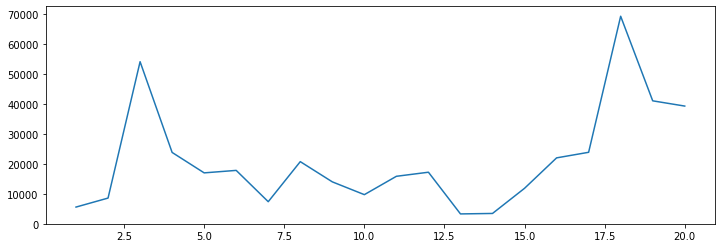

In [ ]:
# Performance plot by sequence length
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = seqsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

X_train: (319, 1, 1) Y_train: (319, 1)
X_test: (126, 1, 1) Y_test: (126, 1)


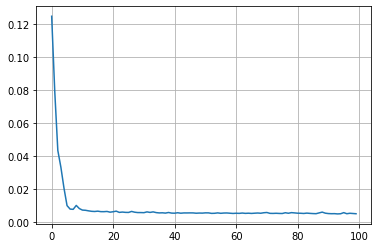

4/4 [==============================] - 1s 5ms/step - loss: 3.4963e-15


MAE      MSE  MAPE
Train 29.04 1,188.83  5.41
Test  54.67 4,323.40  6.00

  5%|▌         | 1/20 [00:28<09:03, 28.58s/it]

X_train: (318, 2, 1) Y_train: (318, 1)
X_test: (125, 2, 1) Y_test: (125, 1)


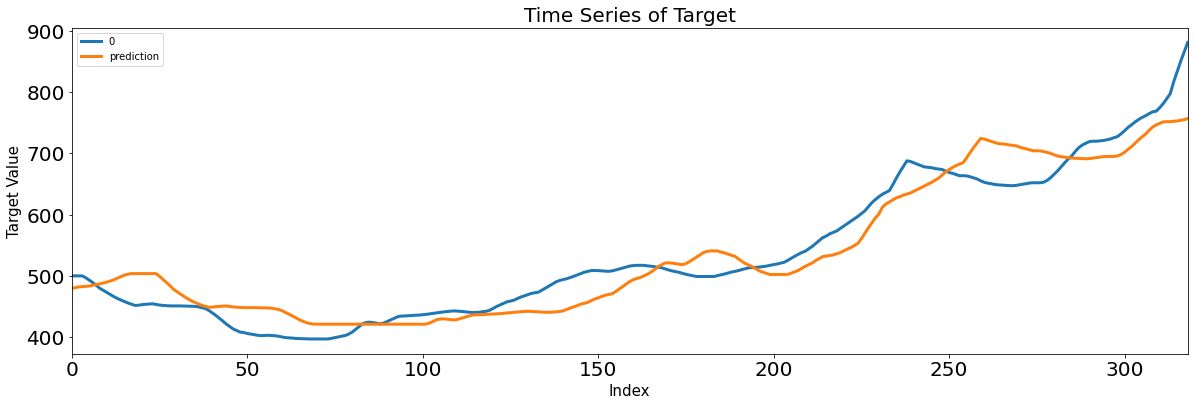

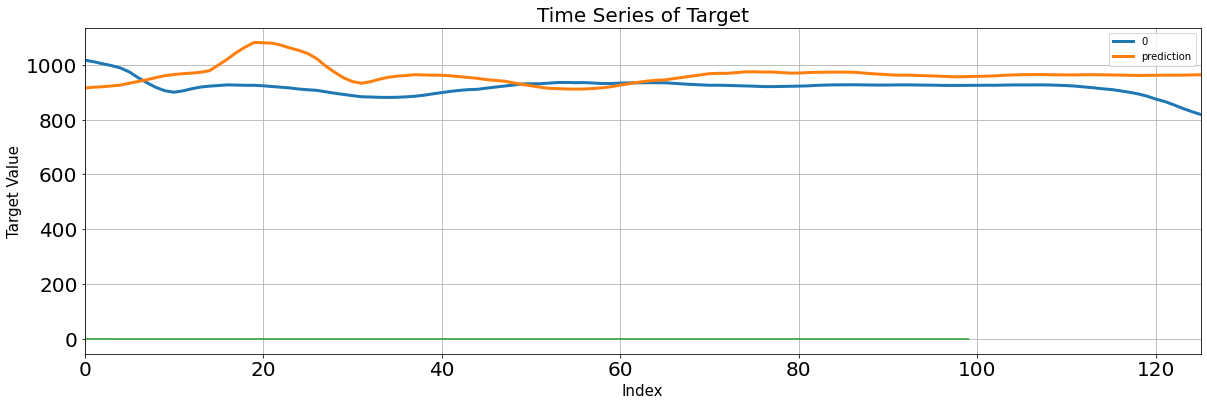

4/4 [==============================] - 1s 8ms/step - loss: 5.0022e-15


MAE       MSE  MAPE
Train  27.56  1,127.67  5.23
Test  223.13 57,055.33 24.46

 10%|█         | 2/20 [01:08<10:37, 35.41s/it]

X_train: (317, 3, 1) Y_train: (317, 1)
X_test: (124, 3, 1) Y_test: (124, 1)


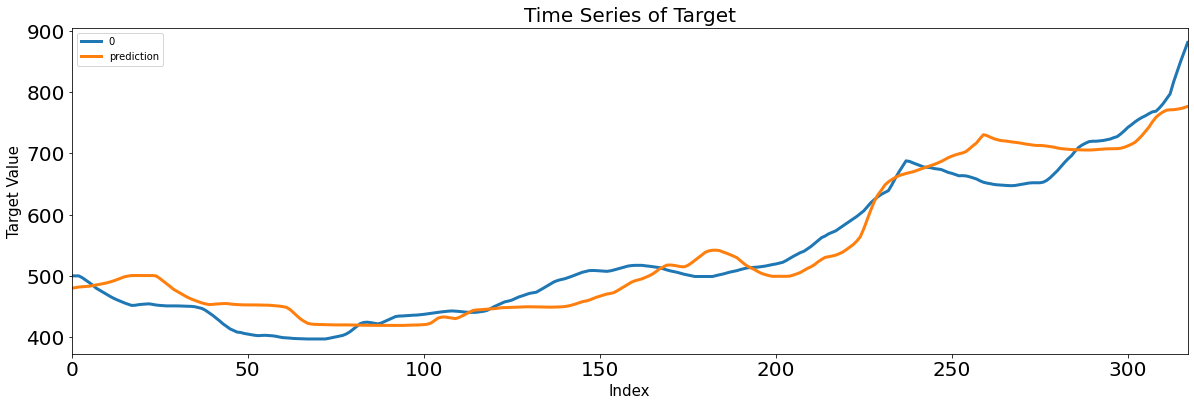

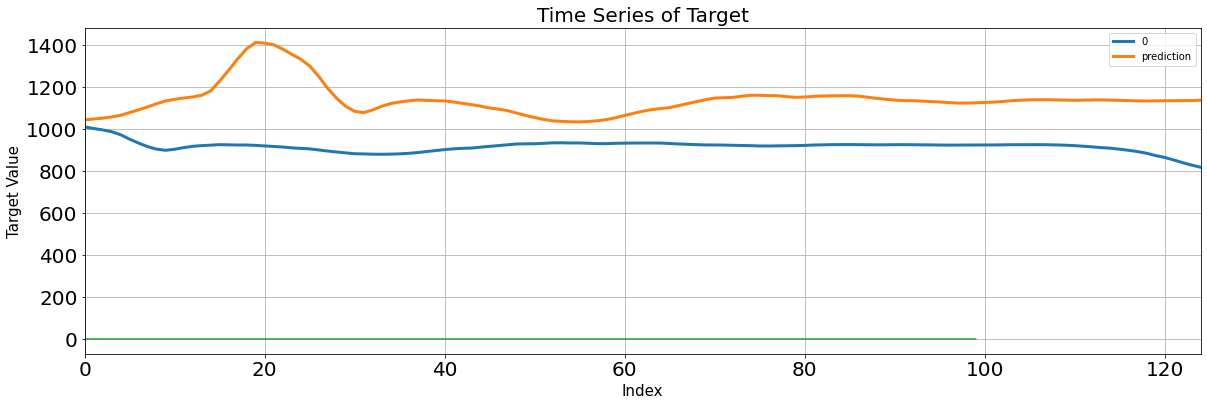

4/4 [==============================] - 1s 10ms/step - loss: 3.6673e-15


MAE      MSE  MAPE
Train 29.45 1,217.11  5.51
Test  79.20 8,745.20  8.72

 15%|█▌        | 3/20 [02:01<12:12, 43.10s/it]

X_train: (316, 4, 1) Y_train: (316, 1)
X_test: (123, 4, 1) Y_test: (123, 1)


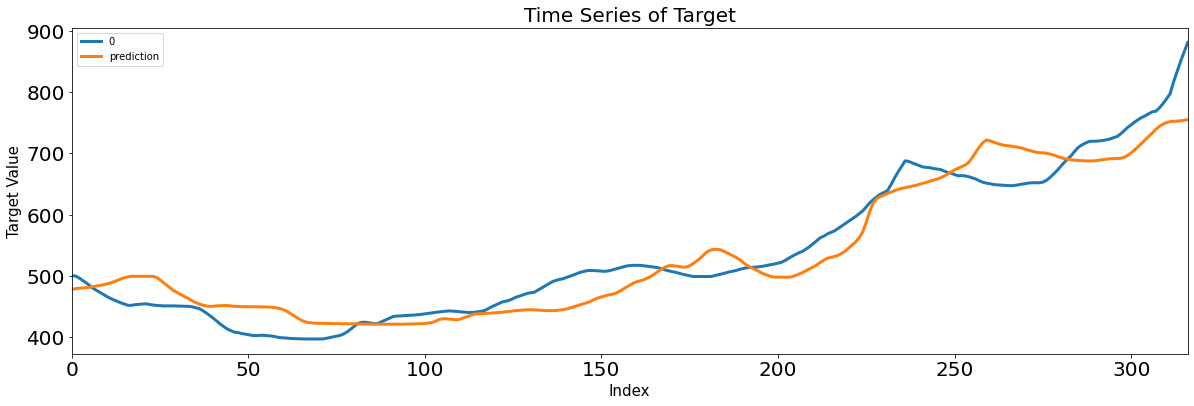

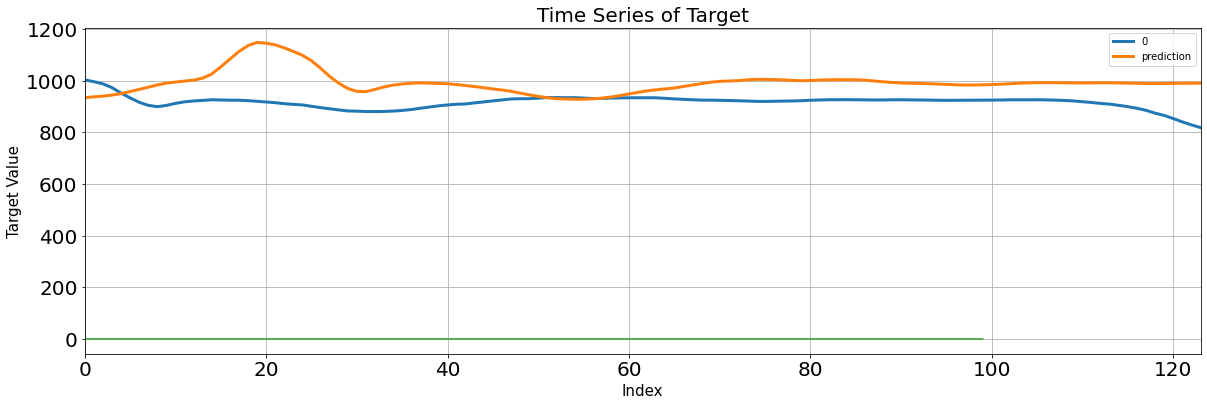

4/4 [==============================] - 1s 13ms/step - loss: 4.7370e-15


MAE      MSE  MAPE
Train 30.35 1,474.43  5.79
Test  26.36 1,406.79  2.90

 20%|██        | 4/20 [03:03<13:32, 50.76s/it]

X_train: (315, 5, 1) Y_train: (315, 1)
X_test: (122, 5, 1) Y_test: (122, 1)


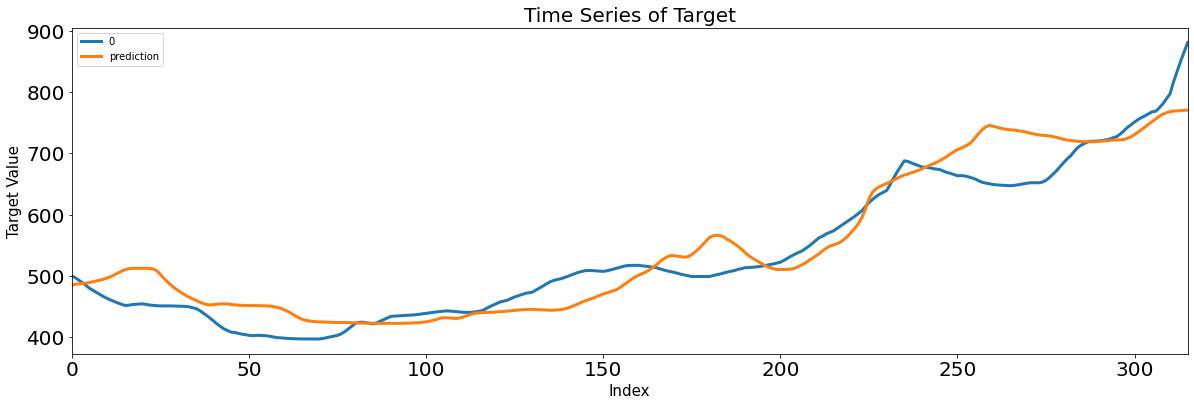

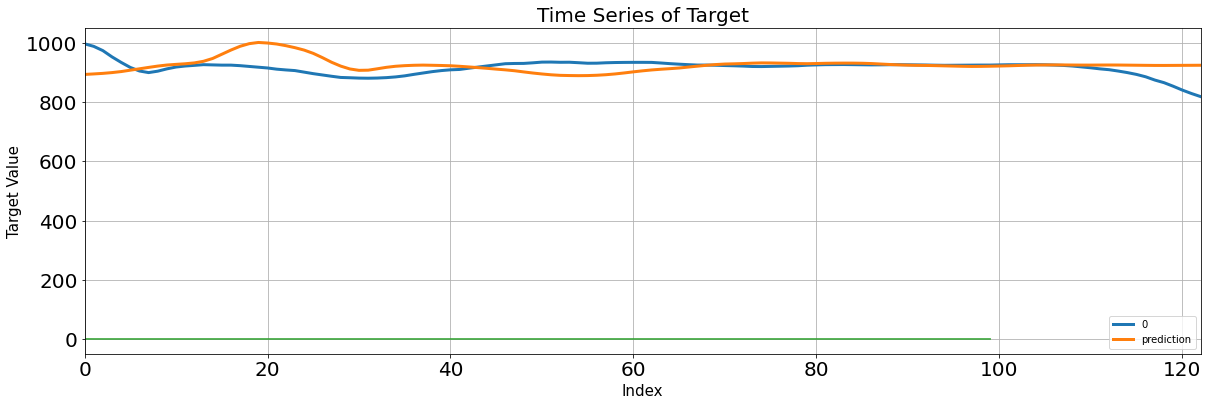

4/4 [==============================] - 1s 14ms/step - loss: 2.1549e-15


MAE      MSE  MAPE
Train 31.66 1,462.86  5.83
Test  33.05 1,674.37  3.60

 25%|██▌       | 5/20 [04:16<14:42, 58.83s/it]

X_train: (314, 6, 1) Y_train: (314, 1)
X_test: (121, 6, 1) Y_test: (121, 1)


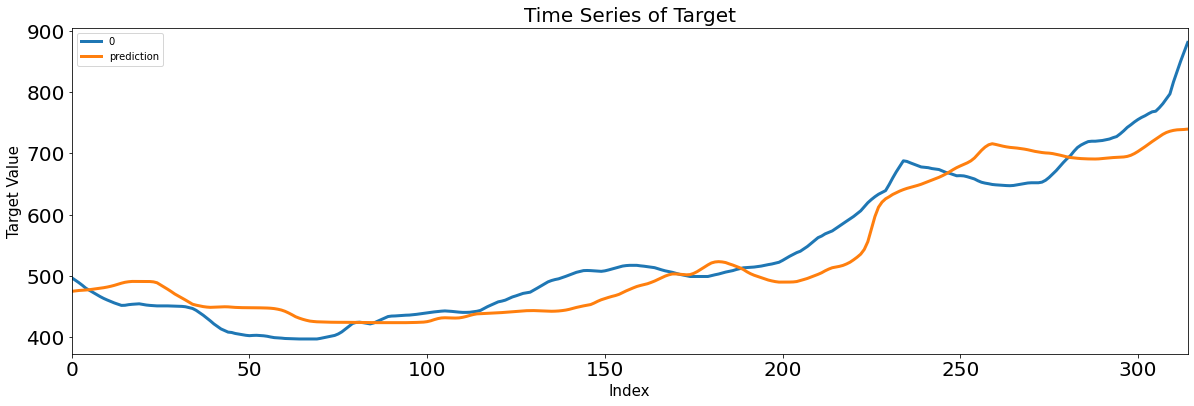

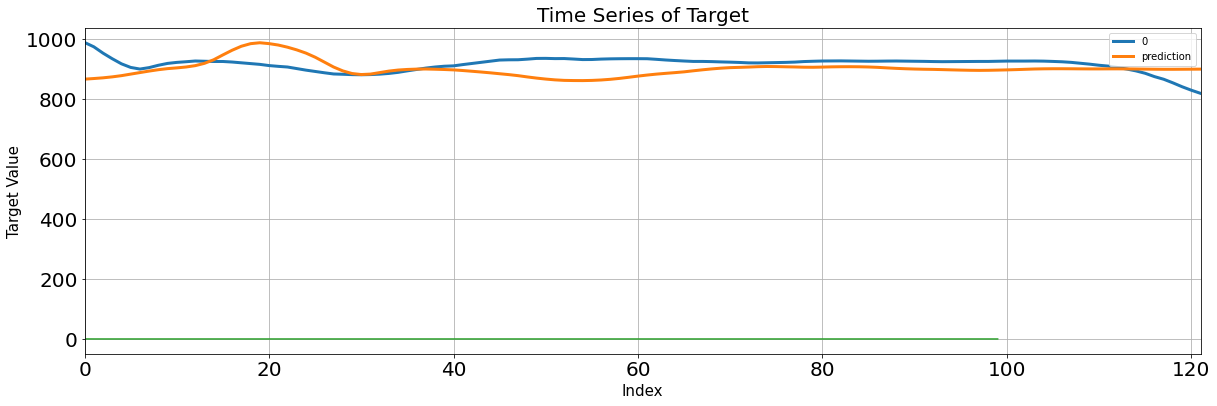

4/4 [==============================] - 1s 16ms/step - loss: 1.6149e-15


MAE      MSE  MAPE
Train 31.26 1,412.96  5.82
Test  67.34 5,225.40  7.30

 30%|███       | 6/20 [05:45<16:04, 68.87s/it]

X_train: (313, 7, 1) Y_train: (313, 1)
X_test: (120, 7, 1) Y_test: (120, 1)


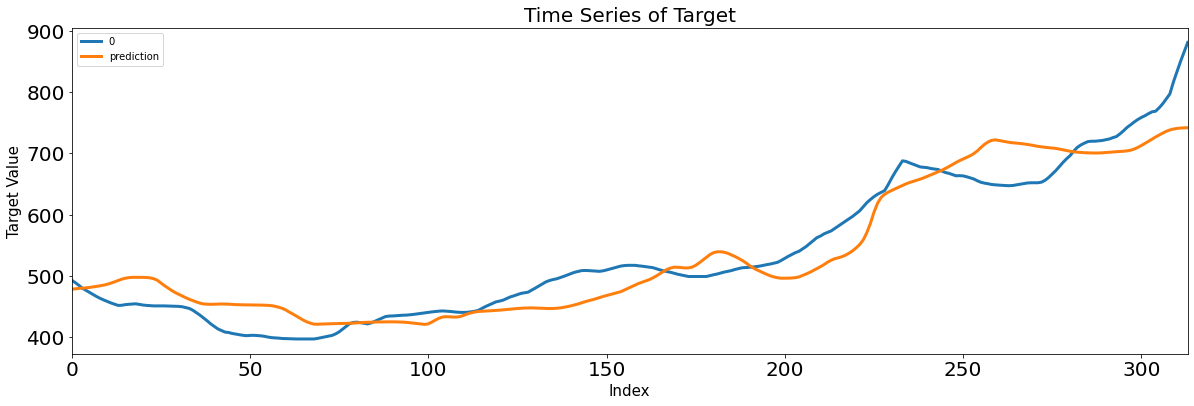

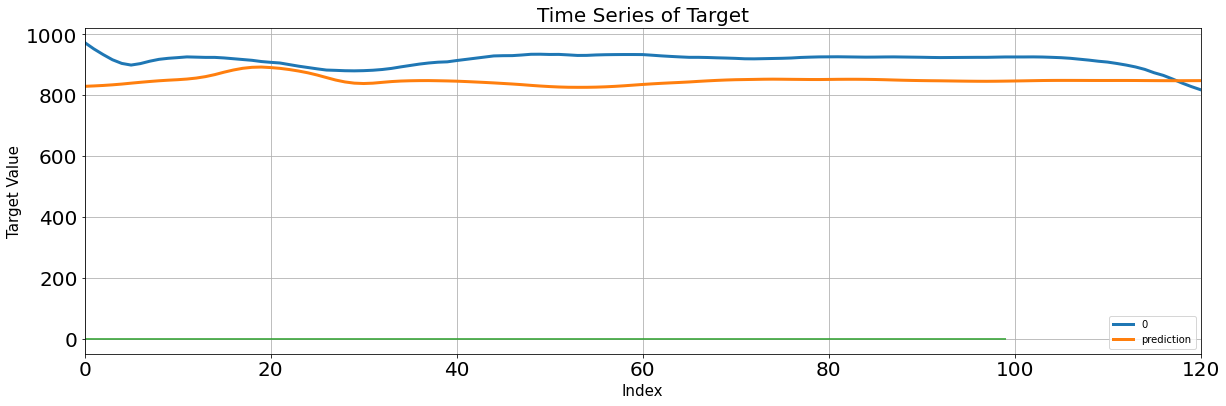

4/4 [==============================] - 1s 17ms/step - loss: 1.3915e-15


MAE      MSE  MAPE
Train 32.47 1,566.91  5.98
Test  69.52 5,456.66  7.55

 35%|███▌      | 7/20 [07:20<16:48, 77.61s/it]

X_train: (312, 8, 1) Y_train: (312, 1)
X_test: (119, 8, 1) Y_test: (119, 1)


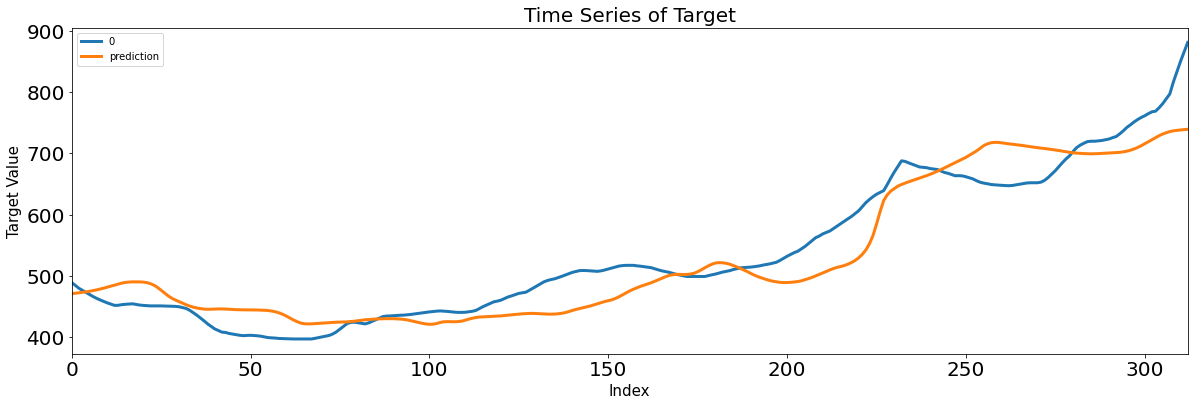

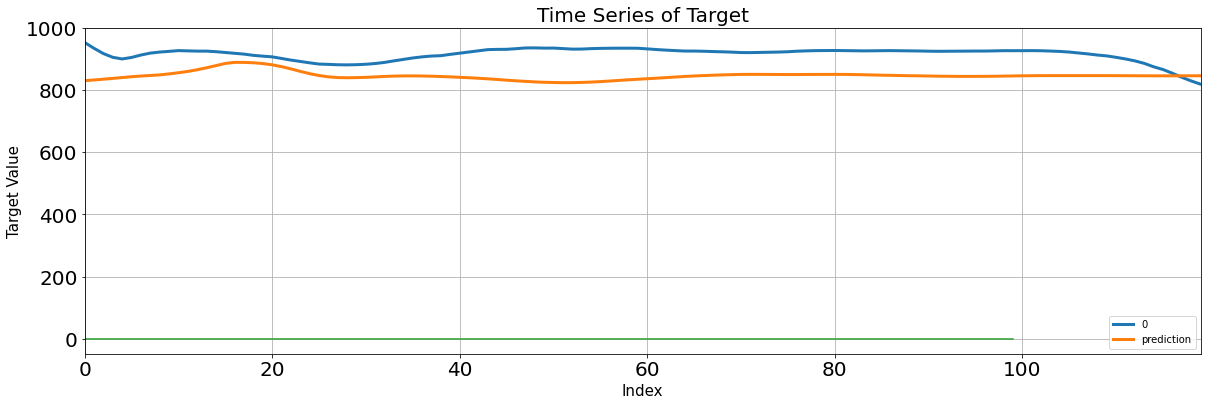

4/4 [==============================] - 1s 27ms/step - loss: 8.9564e-16


MAE      MSE  MAPE
Train 31.10 1,425.68  5.87
Test  96.08 9,781.02 10.46

 40%|████      | 8/20 [09:09<17:31, 87.66s/it]

X_train: (311, 9, 1) Y_train: (311, 1)
X_test: (118, 9, 1) Y_test: (118, 1)


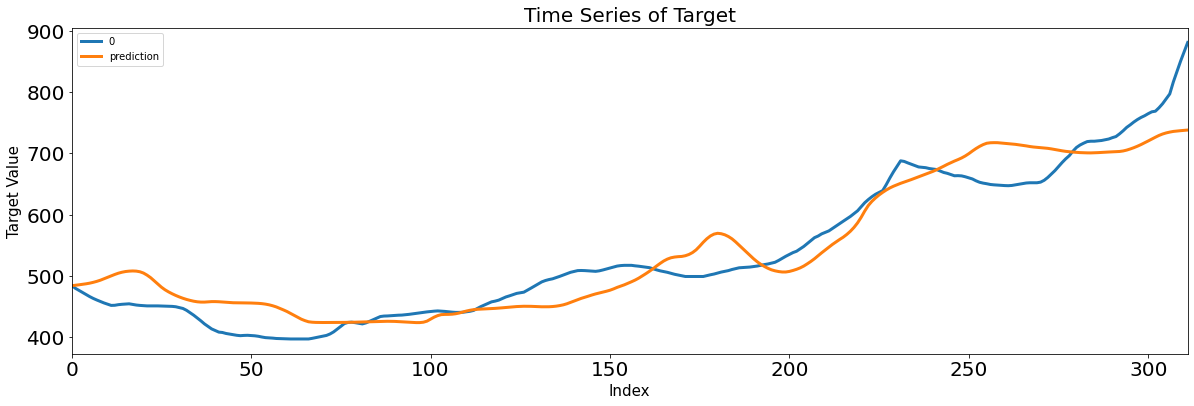

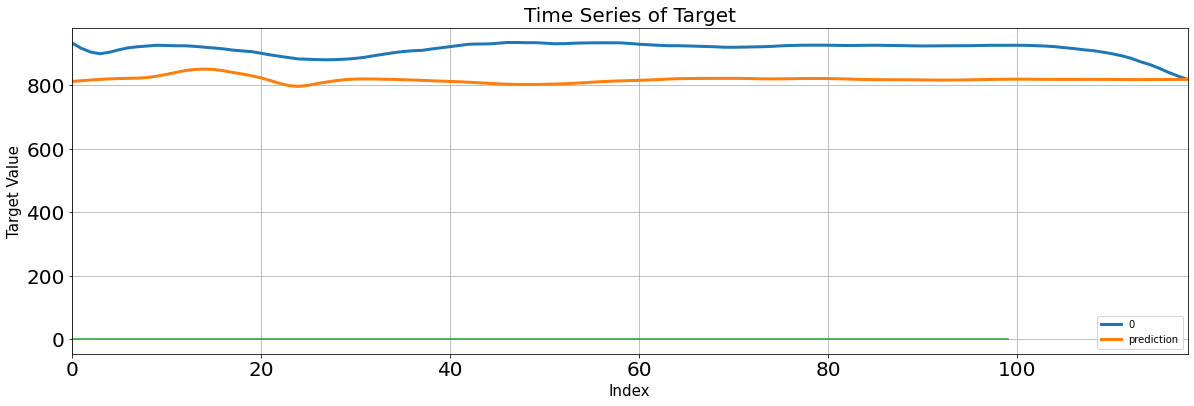

4/4 [==============================] - 1s 31ms/step - loss: 8.7312e-16


MAE      MSE  MAPE
Train 27.15 1,398.31  5.01
Test  80.15 6,966.79  8.71

 45%|████▌     | 9/20 [11:26<18:51, 102.87s/it]

X_train: (310, 10, 1) Y_train: (310, 1)
X_test: (117, 10, 1) Y_test: (117, 1)


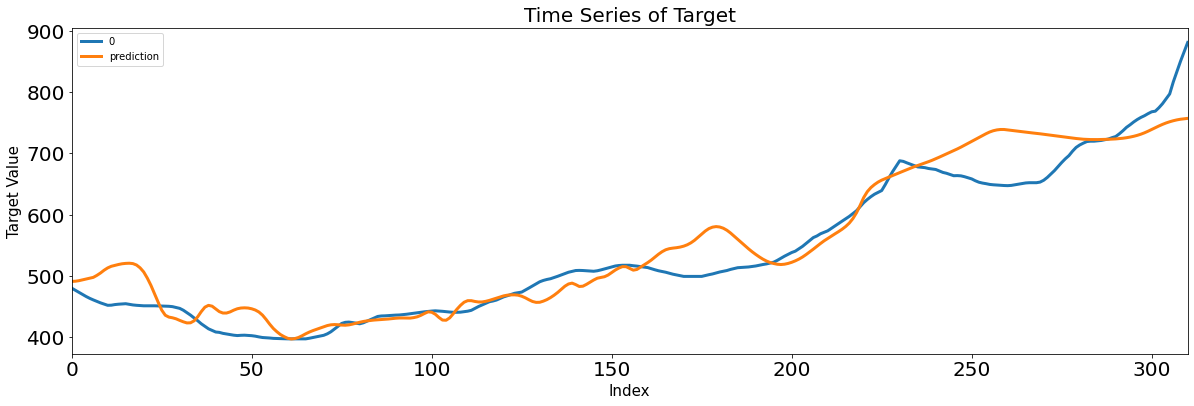

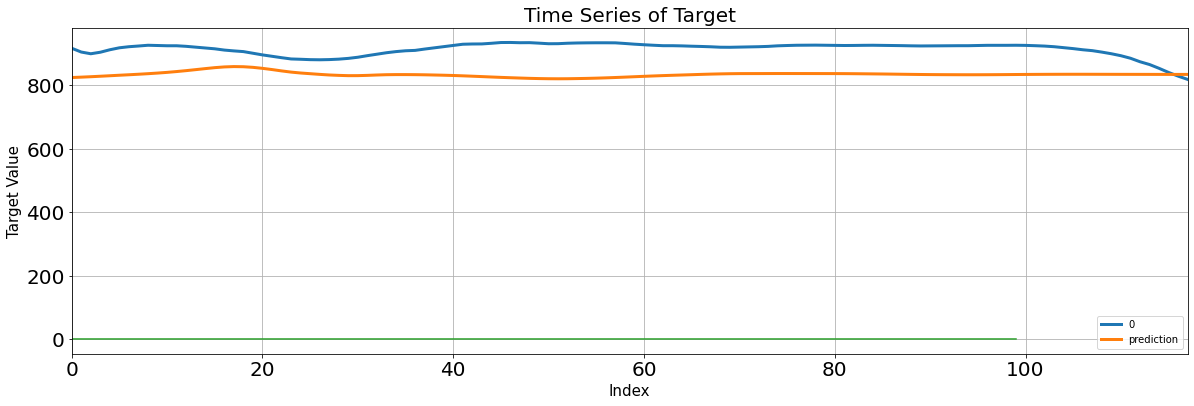

4/4 [==============================] - 1s 30ms/step - loss: 1.6701e-15


MAE      MSE  MAPE
Train 27.85 1,258.16  5.16
Test  79.17 6,773.93  8.62

 50%|█████     | 10/20 [13:47<19:08, 114.84s/it]

X_train: (309, 11, 1) Y_train: (309, 1)
X_test: (116, 11, 1) Y_test: (116, 1)


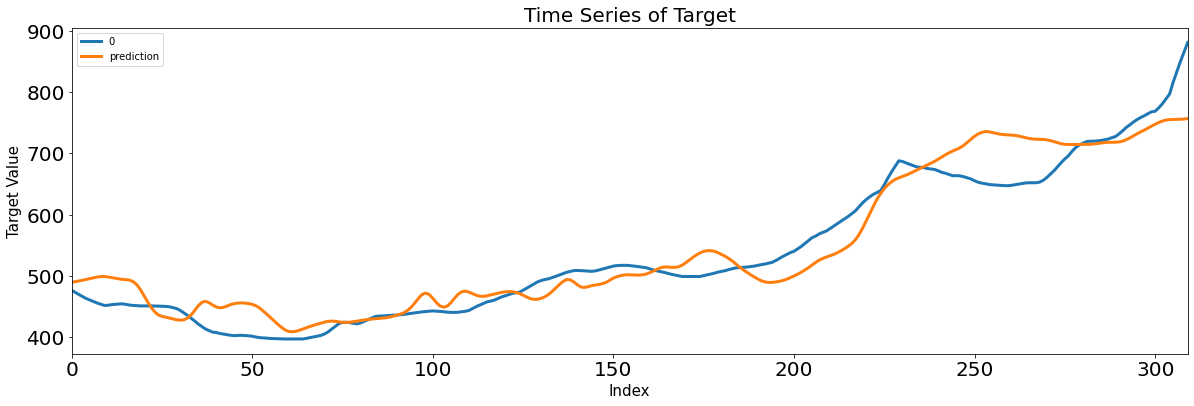

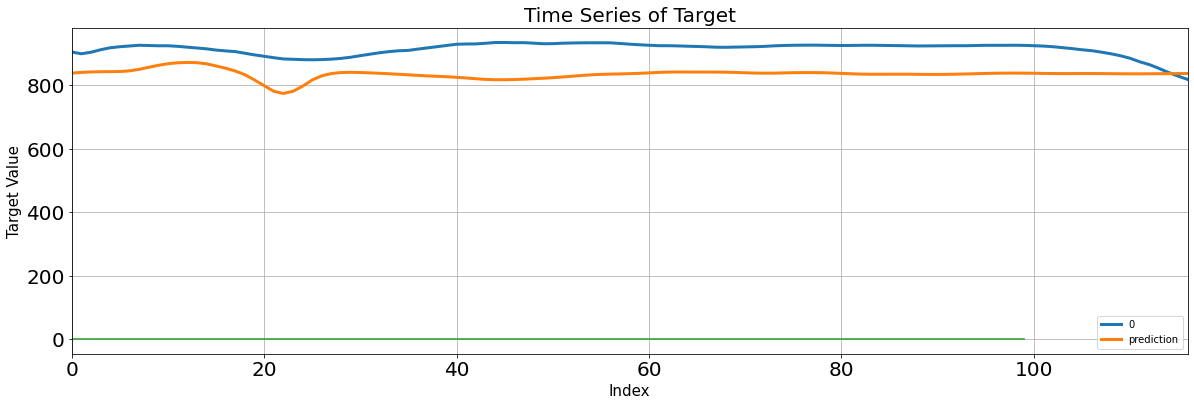

4/4 [==============================] - 1s 30ms/step - loss: 1.2863e-15


MAE      MSE  MAPE
Train 23.83 1,056.47  4.15
Test  90.77 8,835.21  9.87

 55%|█████▌    | 11/20 [16:11<18:32, 123.64s/it]

X_train: (308, 12, 1) Y_train: (308, 1)
X_test: (115, 12, 1) Y_test: (115, 1)


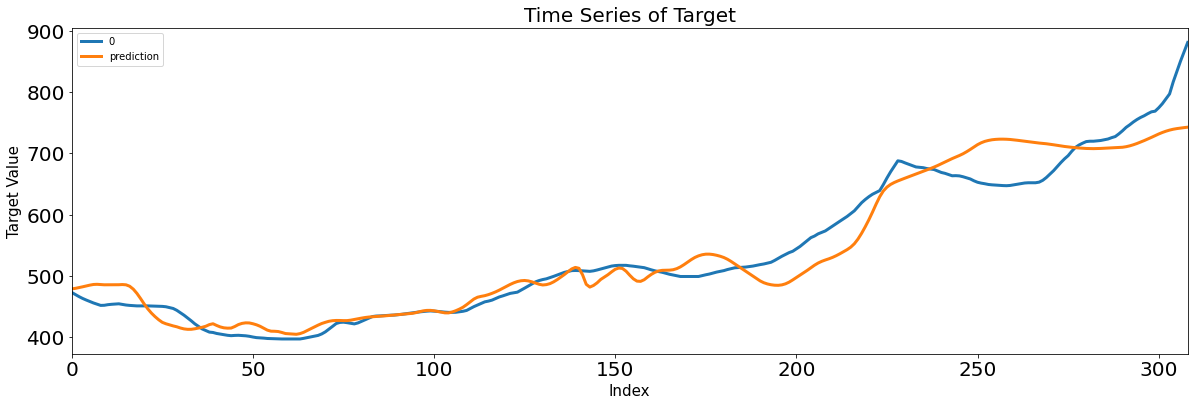

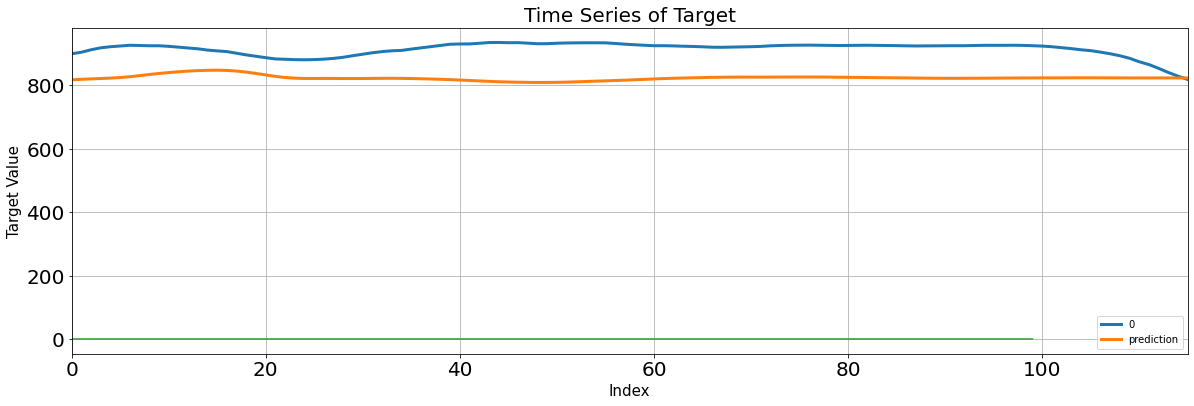

4/4 [==============================] - 1s 31ms/step - loss: 1.2357e-15


MAE       MSE  MAPE
Train  26.54  1,154.12  4.69
Test  106.93 12,068.18 11.64

 60%|██████    | 12/20 [18:44<17:41, 132.66s/it]

X_train: (307, 13, 1) Y_train: (307, 1)
X_test: (114, 13, 1) Y_test: (114, 1)


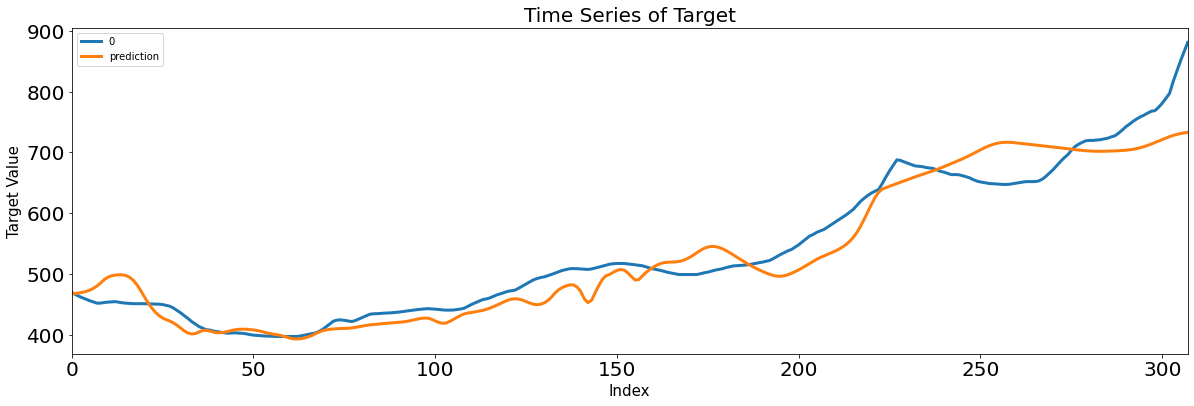

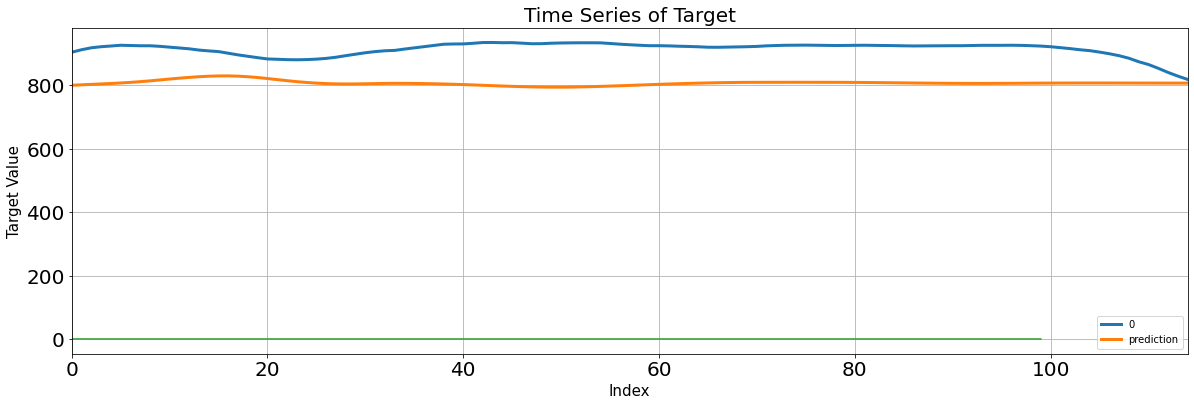

4/4 [==============================] - 1s 33ms/step - loss: 9.0376e-16


MAE       MSE  MAPE
Train  24.32  1,109.91  4.23
Test  135.51 18,910.68 14.76

 65%|██████▌   | 13/20 [21:24<16:26, 140.95s/it]

X_train: (306, 14, 1) Y_train: (306, 1)
X_test: (113, 14, 1) Y_test: (113, 1)


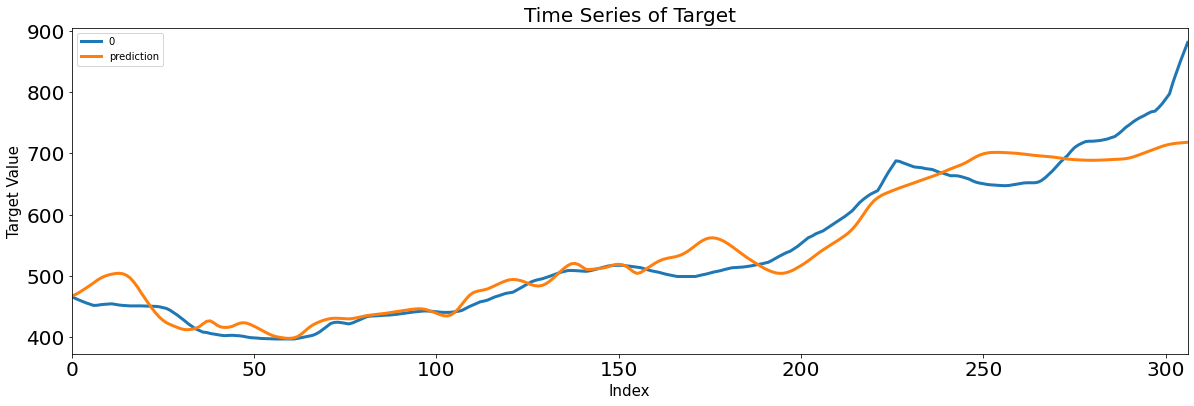

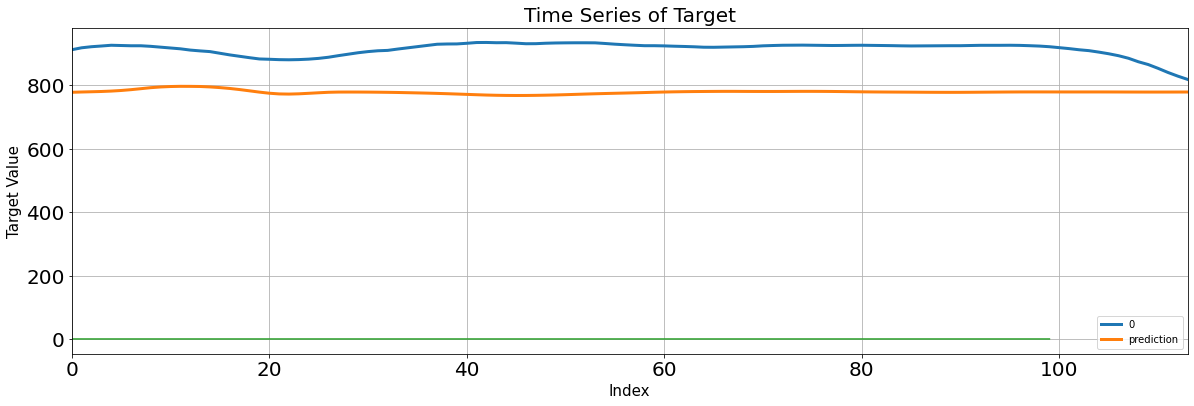

4/4 [==============================] - 1s 35ms/step - loss: 1.8864e-15


MAE       MSE  MAPE
Train  25.17  1,210.32  4.51
Test  100.64 10,679.53 10.95

 70%|███████   | 14/20 [24:18<15:04, 150.80s/it]

X_train: (305, 15, 1) Y_train: (305, 1)
X_test: (112, 15, 1) Y_test: (112, 1)


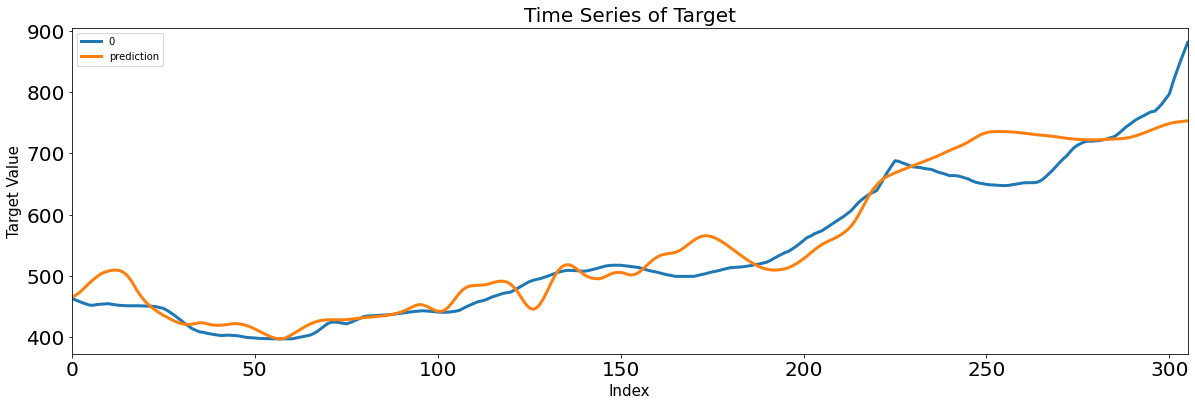

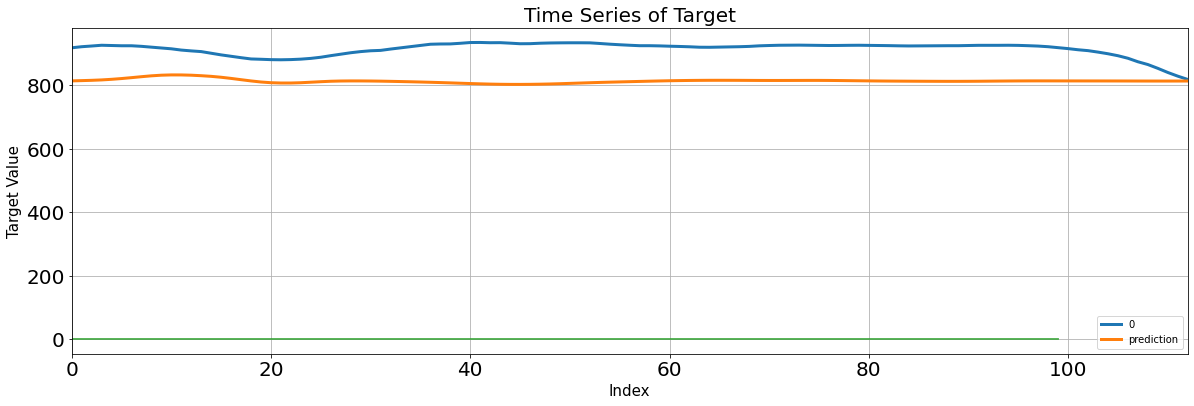

4/4 [==============================] - 1s 37ms/step - loss: 1.6495e-15


MAE       MSE  MAPE
Train  26.22  1,182.59  4.73
Test  126.16 16,483.53 13.74

 75%|███████▌  | 15/20 [27:21<13:23, 160.70s/it]

X_train: (304, 16, 1) Y_train: (304, 1)
X_test: (111, 16, 1) Y_test: (111, 1)


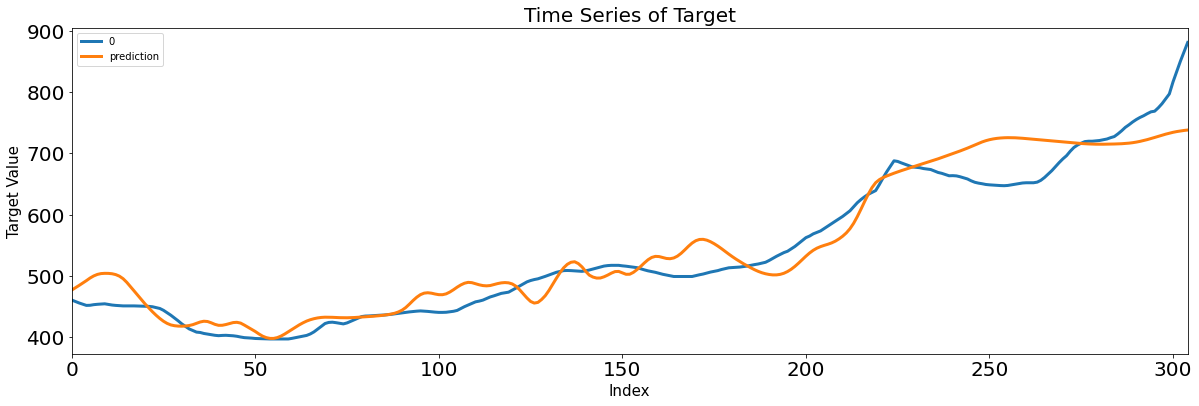

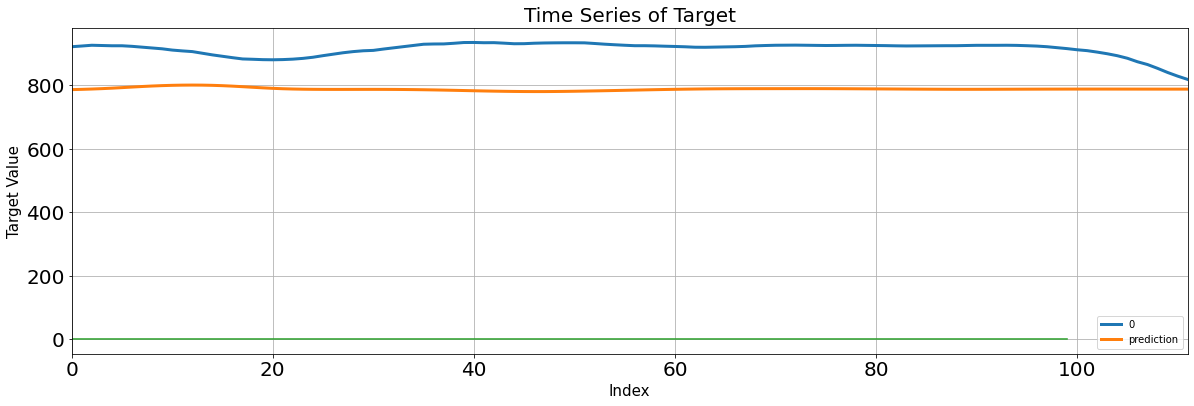

4/4 [==============================] - 1s 40ms/step - loss: 1.1202e-15


MAE       MSE  MAPE
Train  20.76    985.39  3.43
Test  130.01 17,508.52 14.16

 80%|████████  | 16/20 [30:17<11:00, 165.07s/it]

X_train: (303, 17, 1) Y_train: (303, 1)
X_test: (110, 17, 1) Y_test: (110, 1)


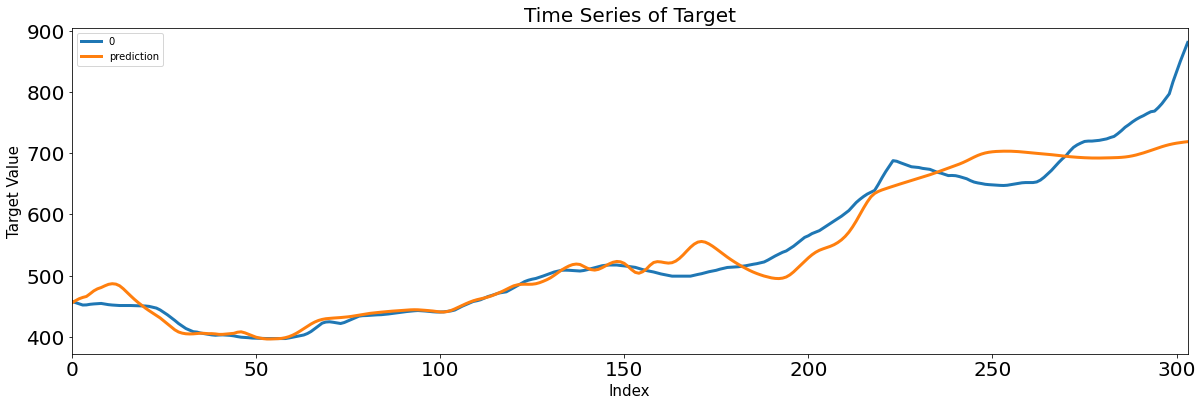

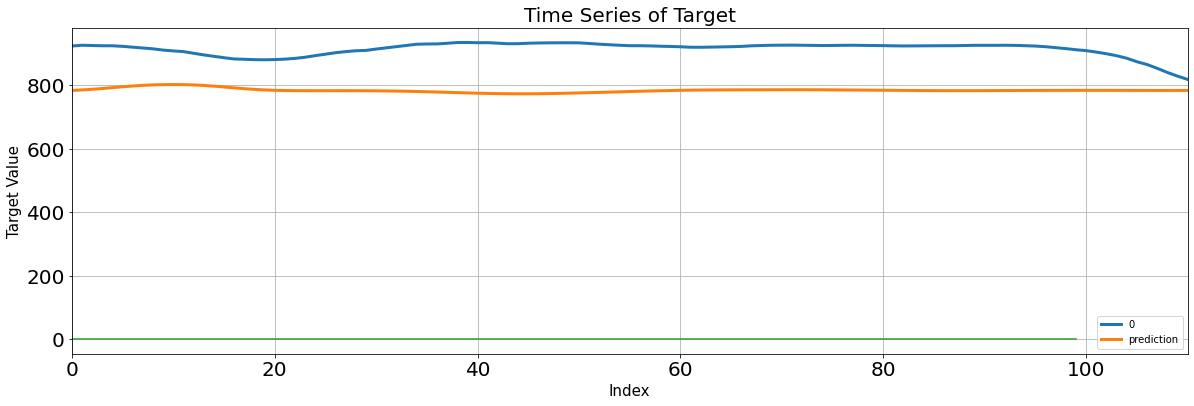

4/4 [==============================] - 1s 40ms/step - loss: 1.9701e-15


MAE       MSE  MAPE
Train  21.95  1,042.47  3.75
Test  101.56 10,894.30 11.05

 85%|████████▌ | 17/20 [33:33<08:43, 174.54s/it]

X_train: (302, 18, 1) Y_train: (302, 1)
X_test: (109, 18, 1) Y_test: (109, 1)


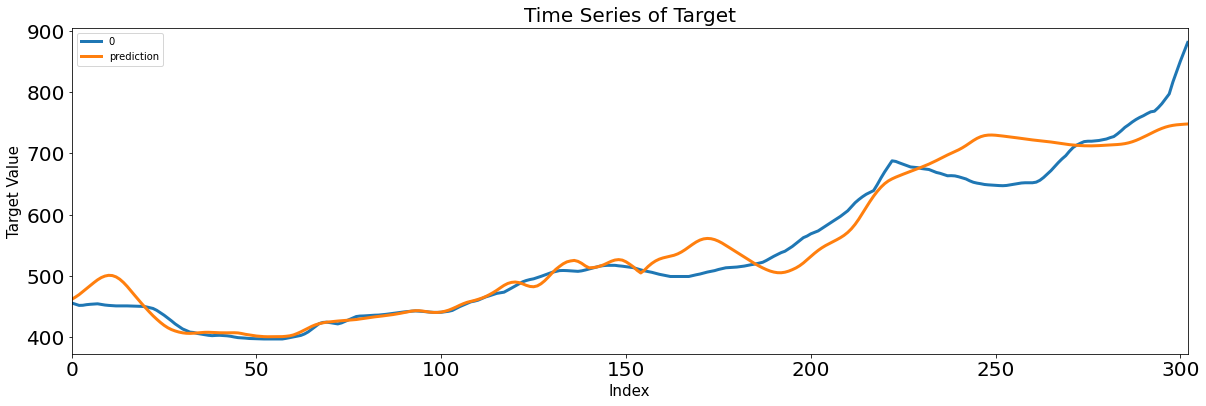

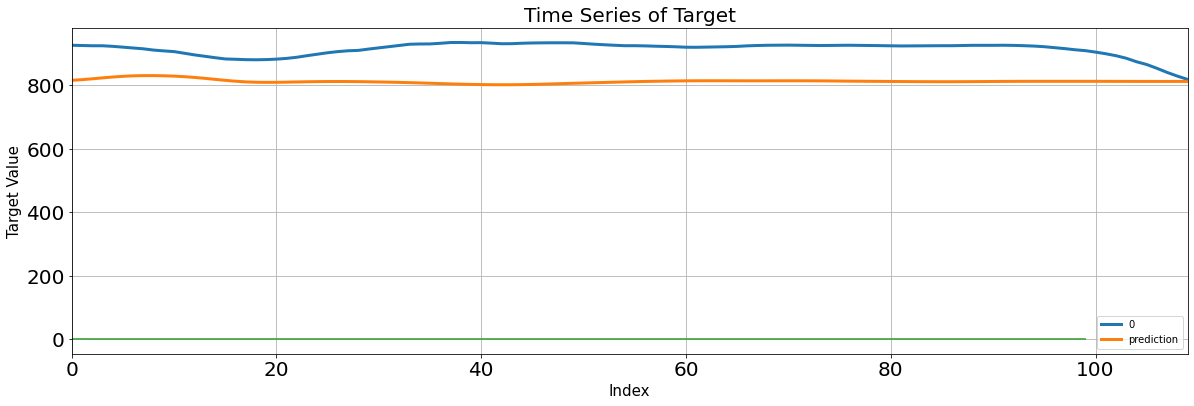

4/4 [==============================] - 1s 51ms/step - loss: 9.1262e-16


MAE       MSE  MAPE
Train  20.31    947.35  3.32
Test  132.73 18,174.94 14.46

 90%|█████████ | 18/20 [37:05<06:11, 185.69s/it]

X_train: (301, 19, 1) Y_train: (301, 1)
X_test: (108, 19, 1) Y_test: (108, 1)


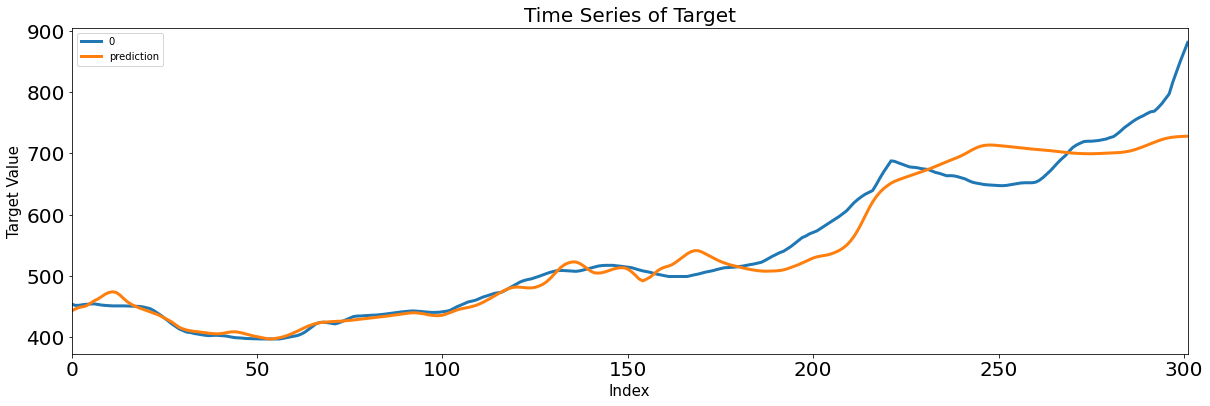

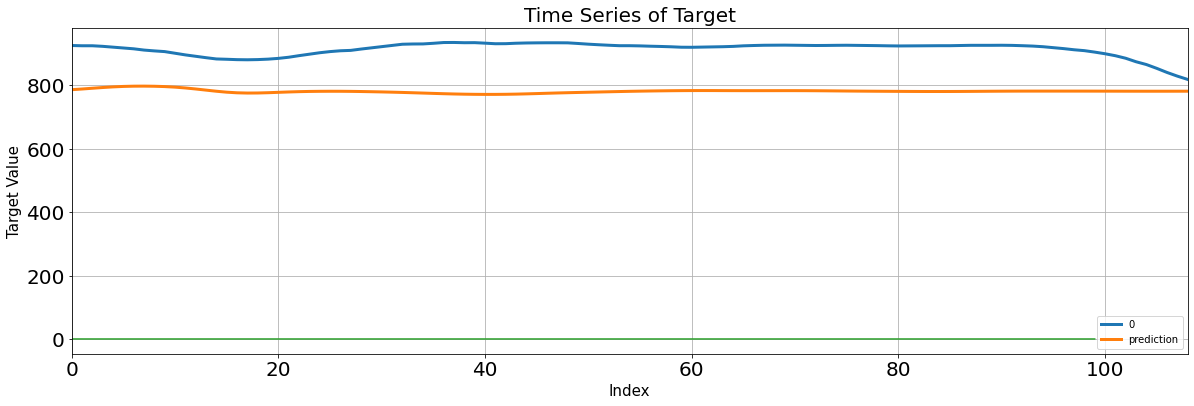

4/4 [==============================] - 1s 52ms/step - loss: 1.3816e-15


MAE       MSE  MAPE
Train  20.49    929.20  3.42
Test  121.65 15,444.64 13.26

 95%|█████████▌| 19/20 [40:46<03:16, 196.30s/it]

X_train: (300, 20, 1) Y_train: (300, 1)
X_test: (107, 20, 1) Y_test: (107, 1)


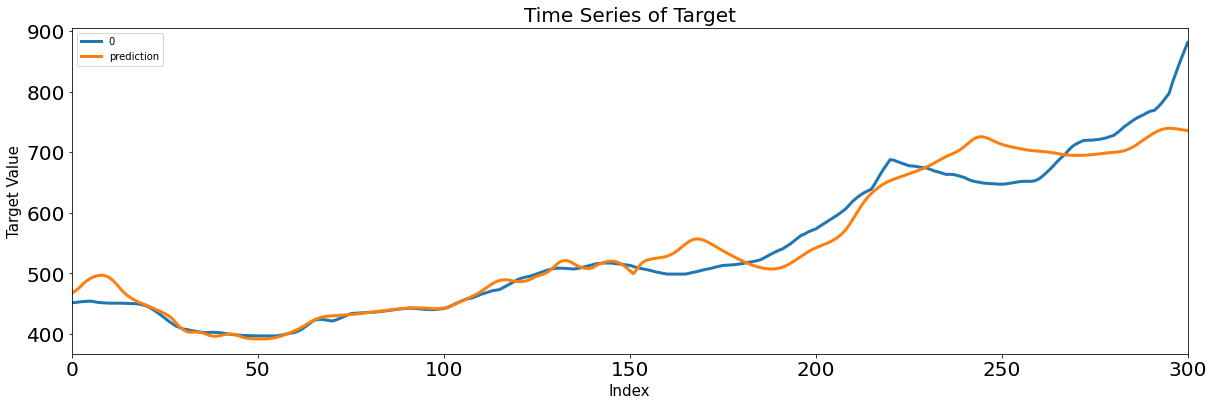

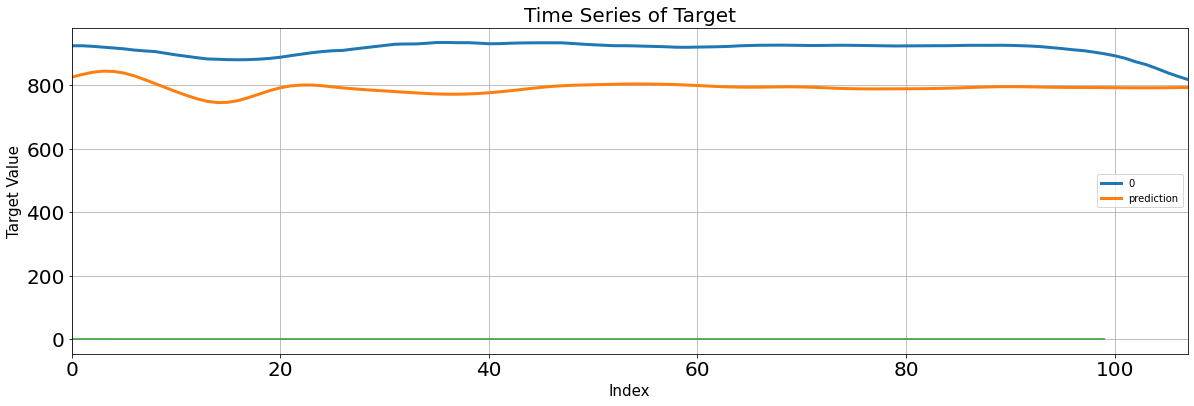

4/4 [==============================] - 1s 54ms/step - loss: 1.3613e-15


MAE      MSE  MAPE
Train 20.75 1,126.94  3.43
Test  72.98 5,857.80  7.93

100%|██████████| 20/20 [44:41<00:00, 134.07s/it]


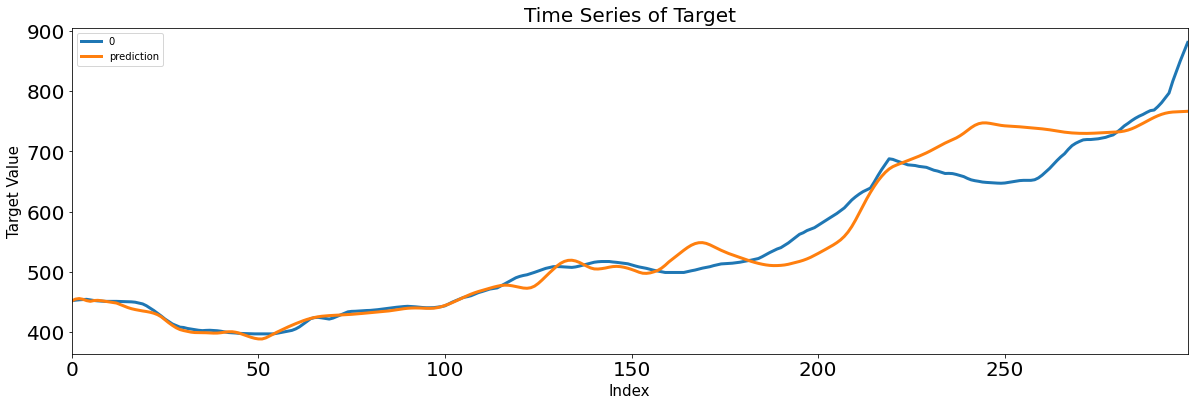

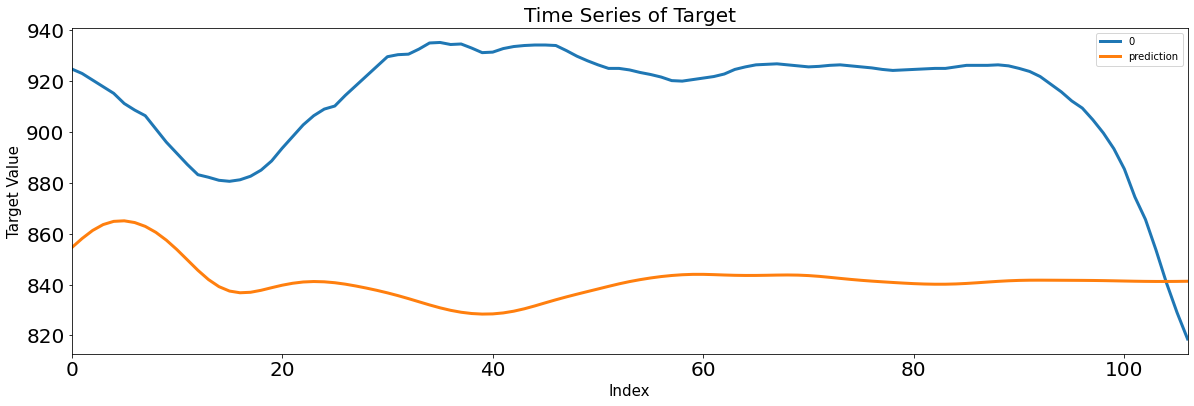

In [ ]:
#################################################################################
#
# ----- Feature 1, LSTM 버전 -------
#
#################################################################################


# Data Loading
# df = pd.read_excel('/content/Rev_dataset.xlsx')
# df.set_index('Date', inplace=True)

# X_colname = ['MA5']
# raw_all = df[X_colname]

# raw_all = df.loc[df['MA5'] != np.nan, :]

#20%는 테스트용 구분함
# PCT = 0.2
# c_num = round(len(raw_all.index) * (1- PCT), 0)

# criteria = raw_all.index[int(c_num)]


# raw_all = df.loc[df.index >= '2019-12-30', X_colname]

# Parameters
# criteria = '2021-09-01'
# scaler = preprocessing.MinMaxScaler()
# sequence = 30
# batch_size = 32
# epoch = 100
# verbose = 1
# dropout_ratio = 0

# # Feature Engineering
# ## Train & Test Split
# train = raw_all.loc[raw_all.index < criteria,:]
# test = raw_all.loc[raw_all.index >= criteria,:]
# print('Train_size:', train.shape, 'Test_size:', test.shape)

# ## Scaling
# train_scaled = scaler.fit_transform(train)
# test_scaled = scaler.transform(test)


####################### iterations #######################
Score = dict()
seqsize_list = [i for i in range(1, 21, 1)]
for i in tqdm(seqsize_list):
    sequence = i
        
    ## X / Y Split
    X_train, Y_train = [], []
    for index in range(0, len(train_scaled) - sequence - predict_day):
        X_train.append(train_scaled[index: index + sequence])
        Y_train.append(train_scaled[index + sequence + predict_day])
    X_test, Y_test = [], []
    for index in range(0, len(test_scaled) - sequence - predict_day):
        X_test.append(test_scaled[index: index + sequence])
        Y_test.append(test_scaled[index + sequence + predict_day])

    ## Retype and Reshape
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # LSTM
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(LSTM(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(LSTM(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(LSTM(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    plt.plot(pd.DataFrame(model_fit.history))
    plt.grid(True)
    plt.show()

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # evaluation
    result = model.evaluate(X_test, Y_test_pred)
    if scaler != []:
        Y_train = scaler.inverse_transform(Y_train)
        Y_train_pred = scaler.inverse_transform(Y_train_pred)
        Y_test = scaler.inverse_transform(Y_test)
        Y_test_pred = scaler.inverse_transform(Y_test_pred)
    Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
    display(Score_LSTM)
    Score[str(sequence)] = Score_LSTM

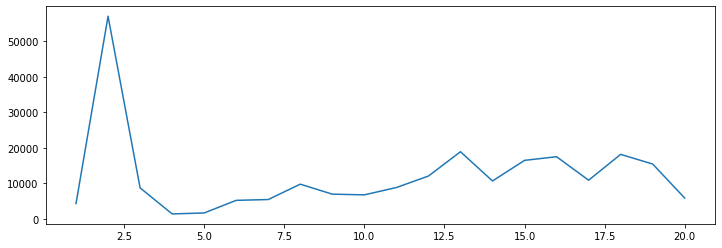

In [ ]:
# Performance plot by sequence length
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = seqsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

Train_size: (390, 1) Test_size: (97, 1)
X_train: (365, 5, 1) Y_train: (365, 1)
X_test: (72, 5, 1) Y_test: (72, 1)


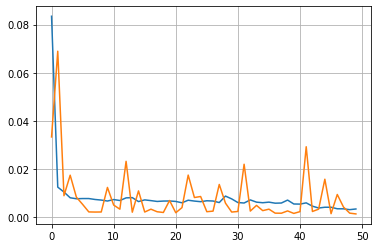

3/3 [==============================] - 0s 12ms/step - loss: 1.1349e-15


MAE      MSE  MAPE
Train 34.67 1,979.00  6.05
Test  18.63   569.83  2.07

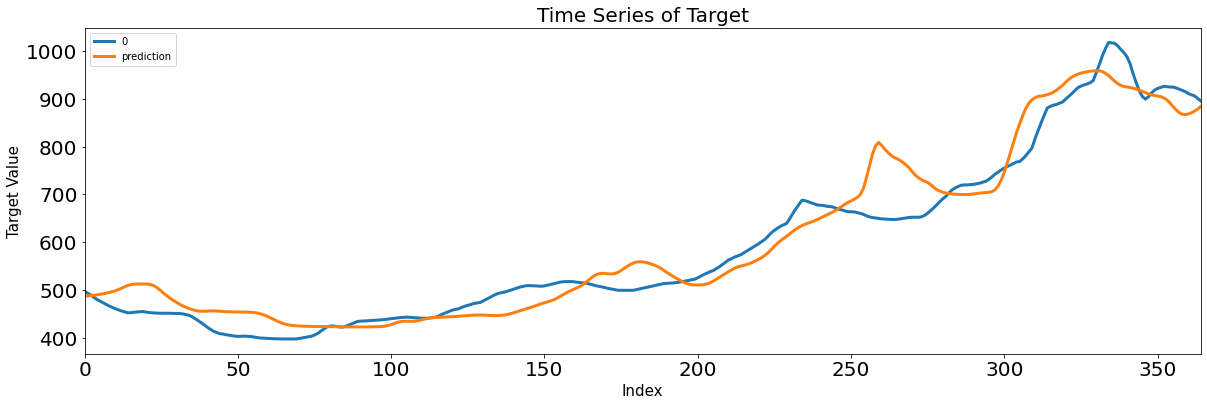

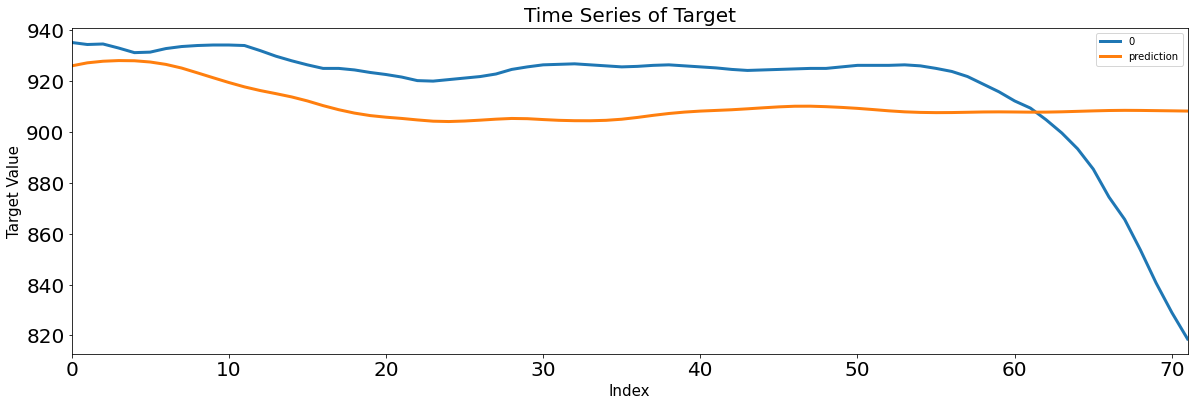

In [107]:
#################################################################################
#
# ----- Feature 1, GRU 버전 -------
#
#################################################################################


# Data Loading
# df = pd.read_excel('/content/Rev_dataset.xlsx')
# df.set_index('Date', inplace=True)

# X_colname = ['MA5']
# raw_all = df[X_colname]

# raw_all = df.loc[df['MA5'] != np.nan, :]

#20%는 테스트용 구분함
PCT = 0.2
c_num = round(len(raw_all.index) * (1- PCT), 0)

criteria = raw_all.index[int(c_num)]


# raw_all = df.loc[df.index >= '2019-12-30', X_colname]

# Parameters
# criteria = '2021-09-01'
# scaler = preprocessing.MinMaxScaler()
# sequence = 30
# batch_size = 32
# epoch = 100
# verbose = 1
# dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

sequence = 5
epoch = 50
batch_size = 16

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 50, mode = 'min')



####################### iterations #######################
# Score = dict()
# batchsize_list = [i for i in range(5, 11, 5)]
# for i in tqdm(batchsize_list):
#     # sequence = i
#     batch_size = i

## X / Y Split
X_train, Y_train = [], []
for index in range(0, len(train_scaled) - sequence - predict_day):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence + predict_day])
X_test, Y_test = [], []
for index in range(0, len(test_scaled) - sequence - predict_day):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence + predict_day])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
# model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose, validation_data=(X_test, Y_test)) #, callbacks = [early_stopping])

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)
# Score[str(batch_size)] = Score_GRU

# error analysis
# error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

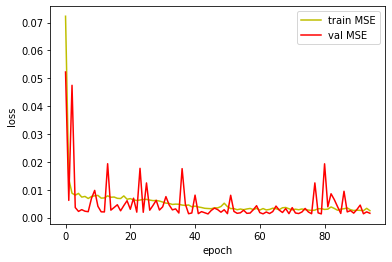

In [ ]:
# 5. 모델 학습과정 표시하기 - epoch 시뮬일 때만 실행
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()

loss_ax.plot(model_fit.history['loss'], 'y', label = 'train MSE')
loss_ax.plot(model_fit.history['val_loss'], 'r', label = 'val MSE')
# acc_ax.plot(model_fit.history['MAE'], 'b', label = 'train MAE')
# acc_ax.plot(model_fit.history['val_MAE'], 'g', label = 'val MAE')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'auto')
# acc_ax.legend(loc = 'lower left')

plt.show()


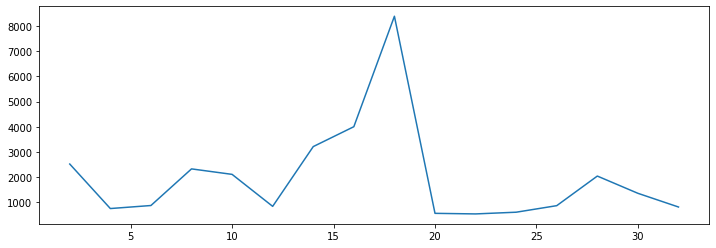

In [ ]:
# Performance plot by sequence length - 시퀀스/배치 변경에 따른 MSE 기록 -> 최적화 찾기 
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = seqsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

In [ ]:
# print(scaler.inverse_transform(X_test[0]))
# print(X_test[0].shape)
# print(Y_test[0])
# print(Y_test_pred[0])